### Need PPT TOO


In [906]:
# Libraries to help with reading and manipulating data
from pprint import pprint
import numpy as np
import pandas as pd
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.core.display import display

# Libraries to tune model, get different metric scores, and split data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn import metrics

# Library to impute missing values
from sklearn.impute import KNNImputer


#libraries to help with model building
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier)
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Library to supress the warning
import warnings
#warnings.filterwarnings('ignore')

In [684]:
interactive_charts = True

random_state = 314159

In [915]:
def make_summary_cols(df, cat_threshold=20):
    '''Create a df to summarise the data df based on dtypes, nulls, numeric or not, categorical or not

    df: data threshold
    cat_threshold: number of unique types below which assume categorical

    returns:
    summary_cols: df of summary
    d: dict of column names where keys are numeric_cols, categorical_cols and non_numeric_cols where
    values against the keys contain corresponding column names
    '''
    types = df.dtypes
    types.name = 'col_types'

    nuniques = data.nunique()
    nuniques.name = 'n_uniques'

    nulls = df.isnull().sum()
    nulls.name = 'nulls'

    summary_cols = pd.merge(left=pd.merge(left=nuniques, right=types, left_index=True, right_index=True), right=nulls,\
                            left_index=True, right_index=True).sort_values(by='col_types')
    summary_cols['isnumeric_column'] = summary_cols['col_types'].apply(lambda x: False if x=='object' else True)

    summary_cols['probably_categorical'] = summary_cols['n_uniques'].apply(lambda x: True if x <=cat_threshold \
        else False)

    d = {
        'numeric_cols': list(summary_cols[summary_cols.isnumeric_column==True].index),
        'categorical_cols': list(summary_cols[summary_cols.probably_categorical==True].index),
        'non_numeric_cols': list(summary_cols[summary_cols.isnumeric_column==False].index)
    }

    return summary_cols, d

def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)},
                                           figsize = figsize
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.displot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, \
            kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram


def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(data[z]) # length of the column
    plt.figure(figsize=(15,5))
    ax = sns.countplot(data[z],palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot

        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage
    plt.show() # show the plot


### Function to plot stacked bar charts for categorical columns
def stacked_plot(feature_name, target_name, df):
    sns.set()
    ## crosstab
    tab1 = pd.crosstab(feature_name,df[target_name],margins=True)#.sort_values(by='yes',ascending=False)
    #print(tab1)
    #print('-'*120)
    ## visualising the cross tab
    tab = pd.crosstab(df[feature_name],df[target_name],normalize='index')#.sort_values(by='yes',ascending=False)
    tab.plot(kind='bar',stacked=True,figsize=(12,5))
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()


### Function to plot distributions and Boxplots of enrollees
def plot_by_target(feature_name,target_name, df):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Existing Customer')
    sns.distplot(df[(df[target_name] == 0)][feature_name],ax=axs[0,0],color='teal')
    axs[0, 1].set_title('Attrited Customer')
    sns.distplot(df[(df[target_name] == 1)][feature_name],ax=axs[0,1],color='orange')
    axs[1,0].set_title('Boxplot w.r.t target')
    sns.boxplot(df[target_name],df[feature_name],ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t target - Without outliers')
    sns.boxplot(df[target_name],df[feature_name],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()



### Function to plot confusion matrix with desriptive labels
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Function to create a summary df with scores on various metrics for each model it is called on
def model_score_df(model, X_train, y_train, X_test, y_test, label='model', score_df=None):
    '''
    model : classifier to predict values of X
    X_train: training data
    y_train: target values in training data
    X_test: testing data
    y_test: target values in testing data
    label: string identifier for model (used in df column names)
    score_df: if None, will create else will append results to score_df

    returns:
    score_df: dataframe with train and test scores for model appended  
    '''
        
    # Scores on Test Data
    y_predict = model.predict(X_test)
    
    
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predict).ravel()
    TNR = TN/(TN+FP)
    FPR = 1-TNR

    x={'model_accuracy':metrics.accuracy_score(y_test, y_predict),
       'model_recall_sensitivity_TPR':metrics.recall_score(y_test, y_predict),
       'model_precision':metrics.precision_score(y_test, y_predict),
       'Specificity_TNR':TNR,
       'model_f1':metrics.f1_score(y_test, y_predict),
       'FPR': FPR}
    
    df1 = pd.DataFrame(x, index=[label+'-test']).T
    
    #display(df1)
    # Scores on Train Data
    y_predict = model.predict(X_train)
    
    TN, FP, FN, TP = metrics.confusion_matrix(y_train, y_predict).ravel()
    TNR = TN/(TN+FP)
    FPR = 1-TNR

    x={'model_accuracy':metrics.accuracy_score(y_train, y_predict),
       'model_recall_sensitivity_TPR':metrics.recall_score(y_train, y_predict),
       'model_precision':metrics.precision_score(y_train, y_predict),
       'Specificity_TNR':TNR,
       'model_f1':metrics.f1_score(y_train, y_predict),
       'FPR': FPR}
    
    df2 = pd.DataFrame(x, index=[label+'-train']).T
    #display(df2)
    
    df_2_1 = pd.merge(df2, df1, left_index=True, right_index=True)
    
    if score_df is None:
        score_df = df_2_1
    else:
        score_df = pd.merge(score_df, df_2_1, left_index=True, right_index=True)
    
    
    return score_df

## 1 Initial Work - Load Data and Inspection

In [686]:
data = pd.read_csv('BankChurners.csv')
display(data.head())
display(data.shape)

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Contacts_Count_12_mon  Credit_Limit  \
0              39  ...                      3       12691.0   
1              44  ...                      2        8256.0   
2              36  ...                      0        3418.0   
3              34  ...                      1        3313.0   
4              21  ...                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   Avg_Utilization_Ratio  Unnamed: 21  
0                  0.061          NaN  
1                  0.105          NaN  
2                  0.000          NaN  
3                  0.760          NaN  
4                  0.000          NaN  

[5 rows x 22 columns]

(10127, 22)

In [687]:
data['CLIENTNUM'].nunique()

10127

In [688]:
data.describe().T

count          mean           std          min  \
CLIENTNUM                 10127.0  7.391776e+08  3.690378e+07  708082083.0   
Customer_Age              10127.0  4.632596e+01  8.016814e+00         26.0   
Dependent_count           10127.0  2.346203e+00  1.298908e+00          0.0   
Months_on_book            10127.0  3.592841e+01  7.986416e+00         13.0   
Total_Relationship_Count  10127.0  3.812580e+00  1.554408e+00          1.0   
Months_Inactive_12_mon    10127.0  2.341167e+00  1.010622e+00          0.0   
Contacts_Count_12_mon     10127.0  2.455317e+00  1.106225e+00          0.0   
Credit_Limit              10127.0  8.631954e+03  9.088777e+03       1438.3   
Total_Revolving_Bal       10127.0  1.162814e+03  8.149873e+02          0.0   
Avg_Open_To_Buy           10127.0  7.469140e+03  9.090685e+03          3.0   
Total_Amt_Chng_Q4_Q1      10127.0  7.599407e-01  2.192068e-01          0.0   
Total_Trans_Amt           10127.0  4.404086e+03  3.397129e+03        510.0   
Total_Trans_Ct            10127.0  6.485869e+01  2.347257e+01         10.0   
Total_Ct_Chng_Q4_Q1       10127.0  7.122224e-01  2.380861e-01          0.0   
Avg_Utilization_Ratio     10127.0  2.748936e-01  2.756915e-01          0.0   
Unnamed: 21                   0.0           NaN           NaN          NaN   

                                   25%           50%           75%  \
CLIENTNUM                 7.130368e+08  7.179264e+08  7.731435e+08   
Customer_Age              4.100000e+01  4.600000e+01  5.200000e+01   
Dependent_count           1.000000e+00  2.000000e+00  3.000000e+00   
Months_on_book            3.100000e+01  3.600000e+01  4.000000e+01   
Total_Relationship_Count  3.000000e+00  4.000000e+00  5.000000e+00   
Months_Inactive_12_mon    2.000000e+00  2.000000e+00  3.000000e+00   
Contacts_Count_12_mon     2.000000e+00  2.000000e+00  3.000000e+00   
Credit_Limit              2.555000e+03  4.549000e+03  1.106750e+04   
Total_Revolving_Bal       3.590000e+02  1.276000e+03  1.784000e+03   
Avg_Open_To_Buy           1.324500e+03  3.474000e+03  9.859000e+03   
Total_Amt_Chng_Q4_Q1      6.310000e-01  7.360000e-01  8.590000e-01   
Total_Trans_Amt           2.155500e+03  3.899000e+03  4.741000e+03   
Total_Trans_Ct            4.500000e+01  6.700000e+01  8.100000e+01   
Total_Ct_Chng_Q4_Q1       5.820000e-01  7.020000e-01  8.180000e-01   
Avg_Utilization_Ratio     2.300000e-02  1.760000e-01  5.030000e-01   
Unnamed: 21                        NaN           NaN           NaN   

                                   max  
CLIENTNUM                 8.283431e+08  
Customer_Age              7.300000e+01  
Dependent_count           5.000000e+00  
Months_on_book            5.600000e+01  
Total_Relationship_Count  6.000000e+00  
Months_Inactive_12_mon    6.000000e+00  
Contacts_Count_12_mon     6.000000e+00  
Credit_Limit              3.451600e+04  
Total_Revolving_Bal       2.517000e+03  
Avg_Open_To_Buy           3.451600e+04  
Total_Amt_Chng_Q4_Q1      3.397000e+00  
Total_Trans_Amt           1.848400e+04  
Total_Trans_Ct            1.390000e+02  
Total_Ct_Chng_Q4_Q1       3.714000e+00  
Avg_Utilization_Ratio     9.990000e-01  
Unnamed: 21                        NaN

* We will examine the distribution and other column characteristics later on - this is a summary for a high level view
* Incorrectly inputted last column 'Unnamed: 21' which we can quickly drop
* From the problem statement we see clientnum is a id which we checked has as many unique values as rows - dropping


In [689]:
print()
data = data.iloc[:,1:-1] # dropping clientnum and last incorrect column
print(f'Data shape after dropping clientnum and last blank col is {data.shape}')


Data shape after dropping clientnum and last blank col is (10127, 20)


In [690]:
data.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

* No null values in dataset - however, as we see later there are 'Unknown' values in categorical columns which need to be treated 

In [691]:
summary_df, sd = make_summary_cols(data)
summary_df

n_uniques col_types  nulls  isnumeric_column  \
Total_Relationship_Count          6     int64      0              True   
Customer_Age                     45     int64      0              True   
Total_Trans_Ct                  126     int64      0              True   
Dependent_count                   6     int64      0              True   
Total_Trans_Amt                5033     int64      0              True   
Total_Revolving_Bal            1974     int64      0              True   
Months_on_book                   44     int64      0              True   
Months_Inactive_12_mon            7     int64      0              True   
Contacts_Count_12_mon             7     int64      0              True   
Total_Amt_Chng_Q4_Q1           1158   float64      0              True   
Avg_Open_To_Buy                6813   float64      0              True   
Credit_Limit                   6205   float64      0              True   
Avg_Utilization_Ratio           964   float64      0              True   
Total_Ct_Chng_Q4_Q1             830   float64      0              True   
Card_Category                     4    object      0             False   
Income_Category                   6    object      0             False   
Marital_Status                    4    object      0             False   
Education_Level                   7    object      0             False   
Gender                            2    object      0             False   
Attrition_Flag                    2    object      0             False   

                          probably_categorical  
Total_Relationship_Count                  True  
Customer_Age                             False  
Total_Trans_Ct                           False  
Dependent_count                           True  
Total_Trans_Amt                          False  
Total_Revolving_Bal                      False  
Months_on_book                           False  
Months_Inactive_12_mon                    True  
Contacts_Count_12_mon                     True  
Total_Amt_Chng_Q4_Q1                     False  
Avg_Open_To_Buy                          False  
Credit_Limit                             False  
Avg_Utilization_Ratio                    False  
Total_Ct_Chng_Q4_Q1                      False  
Card_Category                             True  
Income_Category                           True  
Marital_Status                            True  
Education_Level                           True  
Gender                                    True  
Attrition_Flag                            True

* Here we create a summary table which shows for each column:
 * no of unique values
 * datatype
 * no of nulls
 * is the column numeric?
 * if the column probably categorical (identified as so if the column has 20 or less unique values

In [692]:
numeric_cols = list(summary_df[summary_df.isnumeric_column==True].index)
non_numeric_cols = list(summary_df[summary_df.isnumeric_column==False].index)
categorical_cols = list(summary_df[summary_df.probably_categorical==True].index)
numeric_non_cat_cols = list(summary_df[(summary_df.isnumeric_column==True) & \
                                       (summary_df.probably_categorical==False)].index)

print('numeric_cols are')
pprint(numeric_cols)

print('\nnon numeric cols are')
pprint(non_numeric_cols)

print('\ncategorical cols are')
pprint(categorical_cols)

print('\nnumeric non cat cols are')
pprint(numeric_non_cat_cols)


numeric_cols are
['Total_Relationship_Count',
 'Customer_Age',
 'Total_Trans_Ct',
 'Dependent_count',
 'Total_Trans_Amt',
 'Total_Revolving_Bal',
 'Months_on_book',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Open_To_Buy',
 'Credit_Limit',
 'Avg_Utilization_Ratio',
 'Total_Ct_Chng_Q4_Q1']

non numeric cols are
['Card_Category',
 'Income_Category',
 'Marital_Status',
 'Education_Level',
 'Gender',
 'Attrition_Flag']

categorical cols are
['Total_Relationship_Count',
 'Dependent_count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Card_Category',
 'Income_Category',
 'Marital_Status',
 'Education_Level',
 'Gender',
 'Attrition_Flag']

numeric non cat cols are
['Customer_Age',
 'Total_Trans_Ct',
 'Total_Trans_Amt',
 'Total_Revolving_Bal',
 'Months_on_book',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Open_To_Buy',
 'Credit_Limit',
 'Avg_Utilization_Ratio',
 'Total_Ct_Chng_Q4_Q1']


## 2-A Univariate Analysis
* Lets examine the Numeric non cat cols first

#### 2-A (1) Customer_Age

count    10127.000000
mean        46.325960
std          8.016814
min         26.000000
25%         41.000000
50%         46.000000
75%         52.000000
max         73.000000
Name: Customer_Age, dtype: float64

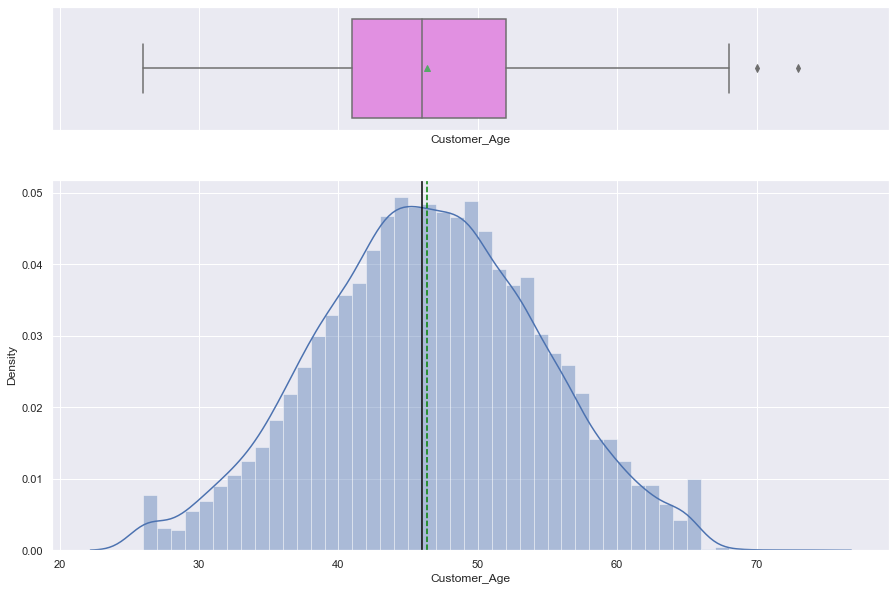

In [693]:
histogram_boxplot(data['Customer_Age'])
data['Customer_Age'].describe()

In [694]:
data['Customer_Age'].value_counts().sort_index()

26     78
27     32
28     29
29     56
30     70
31     91
32    106
33    127
34    146
35    184
36    221
37    260
38    303
39    333
40    361
41    379
42    426
43    473
44    500
45    486
46    490
47    479
48    472
49    495
50    452
51    398
52    376
53    387
54    307
55    279
56    262
57    223
58    157
59    157
60    127
61     93
62     93
63     65
64     43
65    101
66      2
67      4
68      2
70      1
73      1
Name: Customer_Age, dtype: int64

In [919]:
#Using plotly.express to show an interactive chart to quickly check values of outliers without having to write code 
if interactive_charts == True:
    fig = px.box(data['Customer_Age'], orientation='h', height = 250)
    fig.show()

In [918]:
data['Customer_Age'] = data['Customer_Age'].map(lambda x: 65 if x > 65 else x)

#### Customer Age (dtype: int)
* few outliers on the upper end (70, 73)  but otherwise uniformly distributed with mean close to median
* With so few outliers it wont affect model so no need to normalize (check)
* If at all we can cap this distribution 


#### 2-A (2) Total_Trans_Ct

count    10127.000000
mean        64.858695
std         23.472570
min         10.000000
25%         45.000000
50%         67.000000
75%         81.000000
max        139.000000
Name: Total_Trans_Ct, dtype: float64

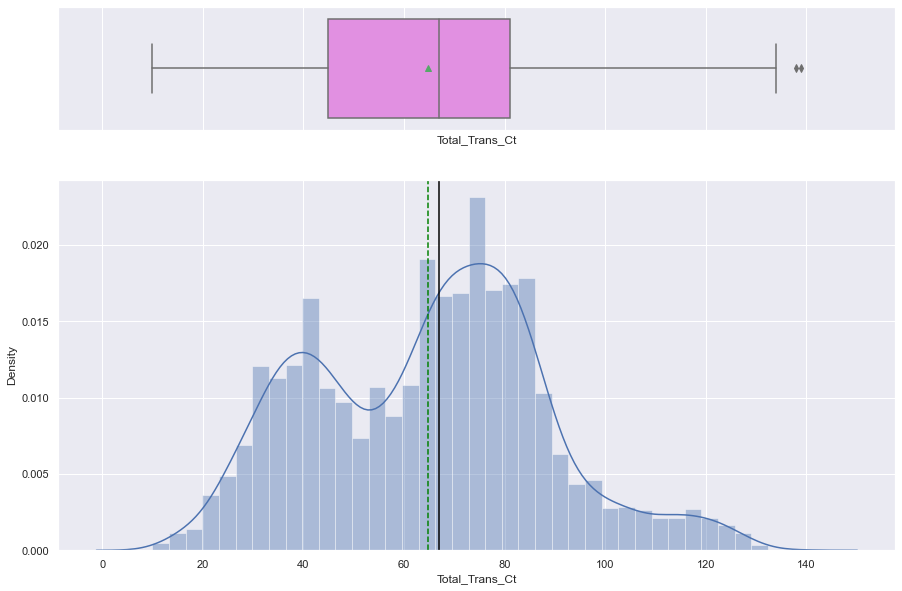

In [696]:
histogram_boxplot(data['Total_Trans_Ct'])
data['Total_Trans_Ct'].describe()

In [697]:
data['Total_Trans_Ct'].value_counts().sort_index()

10     4
11     2
12     4
13     5
14     9
      ..
131    6
132    1
134    1
138    1
139    1
Name: Total_Trans_Ct, Length: 126, dtype: int64

In [922]:
data['Total_Trans_Ct'].sort_values()[-40:]

9511     127
9600     127
9818     127
9300     127
9861     127
9106     127
9258     127
9550     127
9691     127
9813     128
10100    128
9317     128
9983     128
9614     128
9839     128
9646     128
9468     128
9560     128
9563     128
9575     129
9652     129
9595     129
9259     129
9510     129
9431     129
9643     130
9711     130
9960     130
9411     130
10060    130
9728     131
10085    131
9339     131
9841     131
9269     131
9261     131
9629     132
9213     134
9586     138
9324     139
Name: Total_Trans_Ct, dtype: int64

In [698]:
if interactive_charts:
    fig = px.box(data['Total_Trans_Ct'], orientation='h', height = 200)
    fig.show()

#### Total_Trans_Ct (Total Transaction Count - last 12 m) (dtype: int)
* Few outliers on upper end (138, 139)
* Double peaks but mean is close to mean and both near apex of second peak
* One large distribution near 40 and the other around 80
* Perhaps we should create a feature which has <60 and >60 (i.e. trans_ct_is_more_than_60 as binary 0,1


#### 2-A (3) Total_Trans_Amt

count    10127.000000
mean      4404.086304
std       3397.129254
min        510.000000
25%       2155.500000
50%       3899.000000
75%       4741.000000
max      18484.000000
Name: Total_Trans_Amt, dtype: float64

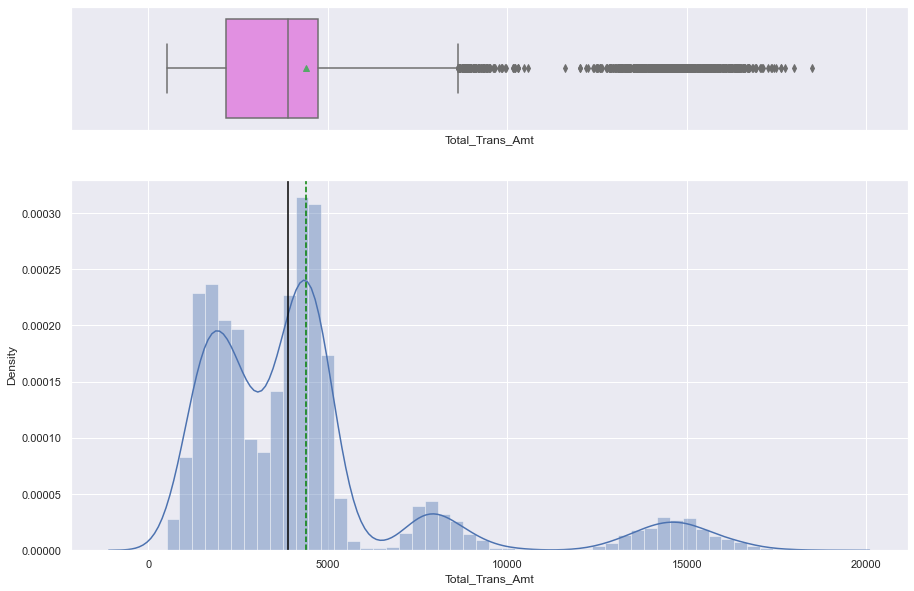

In [699]:
histogram_boxplot(data['Total_Trans_Amt'])
data['Total_Trans_Amt'].describe()

In [700]:
data['Total_Trans_Amt'].value_counts()

4509     11
4253     11
4518     10
2229     10
4042      9
         ..
804       1
2869      1
10468     1
15163     1
8192      1
Name: Total_Trans_Amt, Length: 5033, dtype: int64

In [701]:
if interactive_charts:
    fig = px.box(data['Total_Trans_Amt'], orientation='h', height = 200)
    fig.show()

#### Total_Trans_Amt (Total Transaction Amount - last 12 m) (dtype: int)
* Skewed data set - some collections around 7500-8500 and 15000
* Most data under ~5500 but even that is not uniformly distributed
* Can again consider creating an engineered feature =1 if Total_Trans_Amt > 8618 (upper end of IQR) and 0 if not


#### 2-A (4) Total_Revolving_Bal

count    10127.000000
mean      1162.814061
std        814.987335
min          0.000000
25%        359.000000
50%       1276.000000
75%       1784.000000
max       2517.000000
Name: Total_Revolving_Bal, dtype: float64

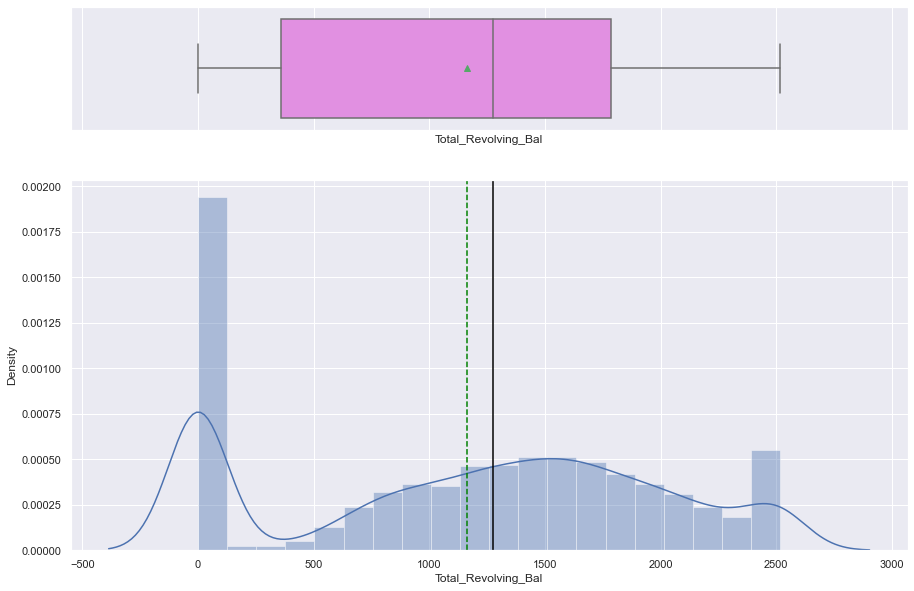

In [702]:
histogram_boxplot(data['Total_Revolving_Bal'])
data['Total_Revolving_Bal'].describe()

In [703]:
data['Total_Revolving_Bal'].nunique()

1974

In [704]:
data['Total_Revolving_Bal'].value_counts().sort_index()

0       2470
132        1
134        1
145        1
154        1
        ... 
2511       1
2512       2
2513       1
2514       3
2517     508
Name: Total_Revolving_Bal, Length: 1974, dtype: int64

In [705]:
if interactive_charts:
    fig = px.box(data['Total_Revolving_Bal'], orientation='h', height = 200)
    fig.show()

#### Total_Revolving_Bal (Total Transaction Amount - last 12 m) (dtype: int)
* 2470 rows with value as 0, 508 with value as 2517
* Has 1974 unique points
* Perhaps can feature engineer to a column which is binary (=0 if this col is 0 and 1 if not) and


#### 2-A (5) Months_on_book

count    10127.000000
mean        35.928409
std          7.986416
min         13.000000
25%         31.000000
50%         36.000000
75%         40.000000
max         56.000000
Name: Months_on_book, dtype: float64

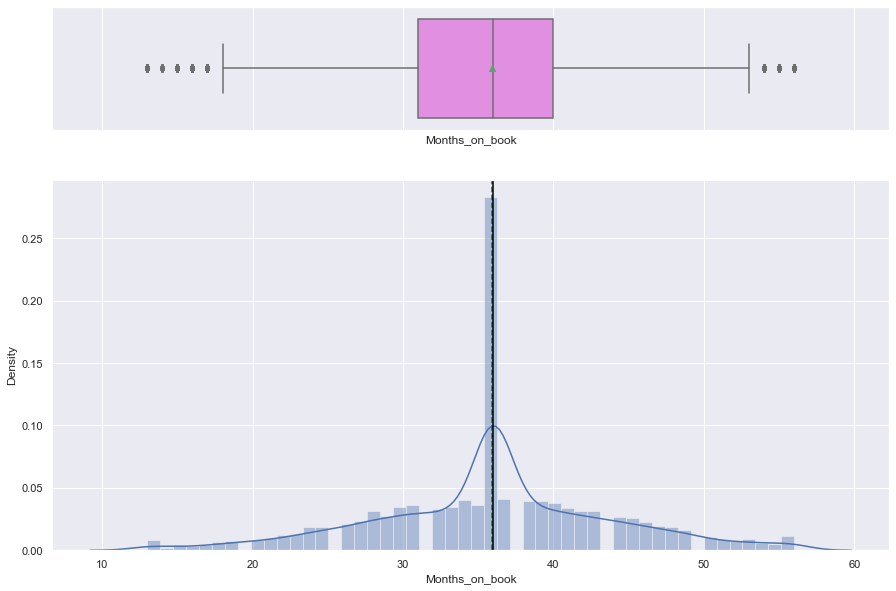

In [706]:
histogram_boxplot(data['Months_on_book'])
data['Months_on_book'].describe()

In [707]:
data['Months_on_book'].nunique()


44

In [708]:
data['Months_on_book'].value_counts().sort_index()

13      70
14      16
15      34
16      29
17      39
18      58
19      63
20      74
21      83
22     105
23     116
24     160
25     165
26     186
27     206
28     275
29     241
30     300
31     318
32     289
33     305
34     353
35     317
36    2463
37     358
38     347
39     341
40     333
41     297
42     271
43     273
44     230
45     227
46     197
47     171
48     162
49     141
50      96
51      80
52      62
53      78
54      53
55      42
56     103
Name: Months_on_book, dtype: int64

In [709]:
if interactive_charts:
    fig = px.box(data['Months_on_book'], orientation='h', height = 200)
    fig.show()

#### Months_on_book (dtype: int)
* outliers: 5 points below IQR and 3 above (13, 14 , 15, 16, 17 and 54,55,56)
    * very few outliers - will perhaps cap them
* 2463 rows with 36 months (which is approx equal to mean)
* distribution is not skewed


#### 2-A (6) Total_Amt_Chng_Q4_Q1

count    10127.000000
mean         0.759941
std          0.219207
min          0.000000
25%          0.631000
50%          0.736000
75%          0.859000
max          3.397000
Name: Total_Amt_Chng_Q4_Q1, dtype: float64

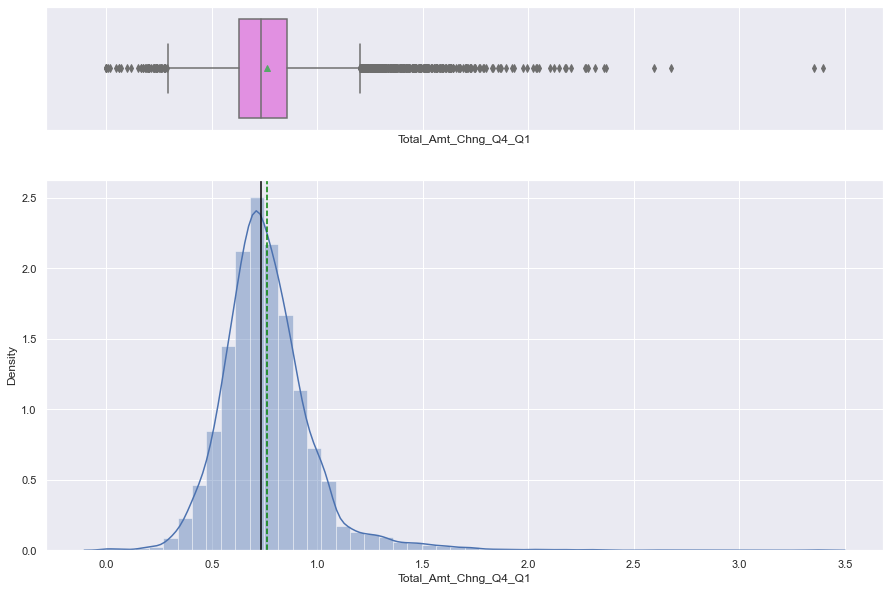

In [710]:
histogram_boxplot(data['Total_Amt_Chng_Q4_Q1'])
data['Total_Amt_Chng_Q4_Q1'].describe()

In [711]:
data['Total_Amt_Chng_Q4_Q1'].nunique()

1158

In [712]:
data['Total_Amt_Chng_Q4_Q1'].value_counts().sort_index()

0.000    5
0.010    1
0.018    1
0.046    1
0.061    2
        ..
2.368    1
2.594    1
2.675    1
3.355    1
3.397    1
Name: Total_Amt_Chng_Q4_Q1, Length: 1158, dtype: int64

In [713]:
if interactive_charts:
    fig = px.box(data['Total_Amt_Chng_Q4_Q1'], orientation='h', height = 200)
    fig.show()

#### Total_Amt_Chng_Q4_Q1 (dtype: float)
* Quite a few outliers above and below IQR bounds
* 1158 unique values
* distribution is silghtly skewed (mean ~= median)
* we may consider normalising this to see impact on model


#### 2-A (7) Avg_Open_To_Buy

count    10127.000000
mean      7469.139637
std       9090.685324
min          3.000000
25%       1324.500000
50%       3474.000000
75%       9859.000000
max      34516.000000
Name: Avg_Open_To_Buy, dtype: float64

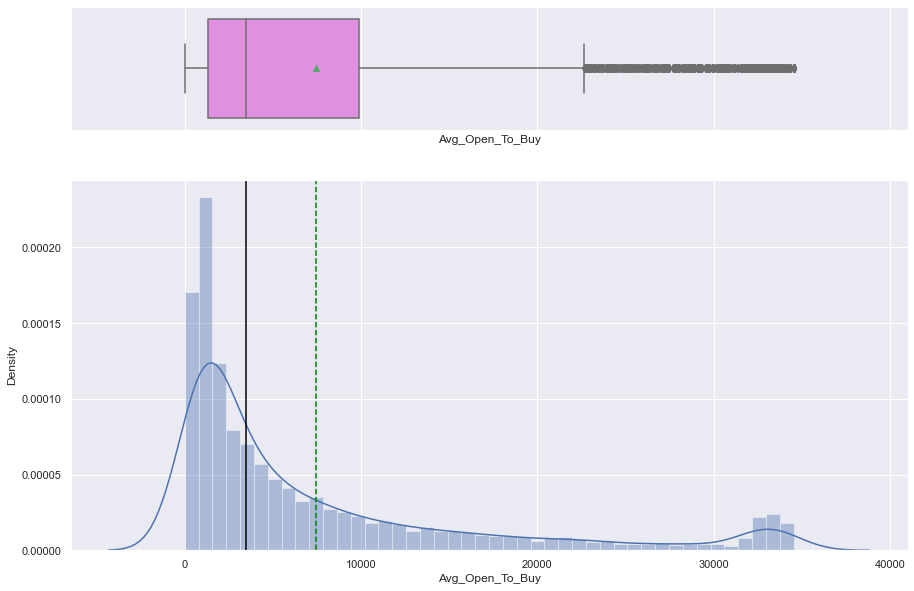

In [714]:
histogram_boxplot(data['Avg_Open_To_Buy'])
data['Avg_Open_To_Buy'].describe()

In [715]:
data['Avg_Open_To_Buy'].nunique()

6813

In [716]:
data['Avg_Open_To_Buy'].value_counts().sort_index()

3.0         1
10.0        1
14.0        2
15.0        1
24.0        1
           ..
34297.0     1
34300.0     1
34302.0     1
34362.0     1
34516.0    98
Name: Avg_Open_To_Buy, Length: 6813, dtype: int64

In [717]:
if interactive_charts:
    fig = px.box(data['Avg_Open_To_Buy'], orientation='h', height = 200)
    fig.show()

#### Avg_Open_To_Buy (dtype: float)
* Quite a few outliers above IQR bounds
* 6813 unique values
* distribution is right skewed (mean > median)
* we may consider normalising this to see if beneficial impact on model


#### 2-A (8) Credit_Limit

count    10127.000000
mean      8631.953698
std       9088.776650
min       1438.300000
25%       2555.000000
50%       4549.000000
75%      11067.500000
max      34516.000000
Name: Credit_Limit, dtype: float64

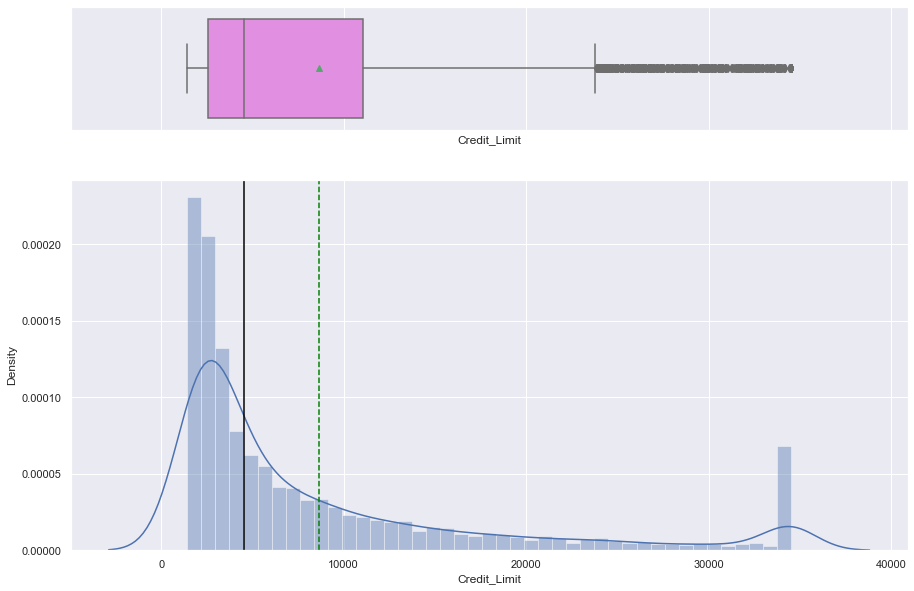

In [718]:
histogram_boxplot(data['Credit_Limit'])
data['Credit_Limit'].describe()

In [719]:
data['Credit_Limit'].nunique()

6205

In [720]:
data['Credit_Limit'].value_counts().sort_index()

1438.3     507
1439.0       2
1440.0       1
1441.0       2
1442.0       1
          ... 
34198.0      1
34427.0      1
34458.0      1
34496.0      1
34516.0    508
Name: Credit_Limit, Length: 6205, dtype: int64

In [721]:
if interactive_charts:
    fig = px.box(data['Credit_Limit'], orientation='h', height = 200)
    fig.show()

#### Credit_Limit (dtype: float)
* Quite a few outliers above IQR bounds
* 6205 unique values
* distribution is right skewed (mean > median)
* Large no of rows at 34516 - max value
    * possible approach could be to cap values at some point say iqr upper bound and create a new feature = 1 where
    the row is above IQR and 0 otherwise


#### 2-A (9) Avg_Utilization_Ratio

count    10127.000000
mean         0.274894
std          0.275691
min          0.000000
25%          0.023000
50%          0.176000
75%          0.503000
max          0.999000
Name: Avg_Utilization_Ratio, dtype: float64

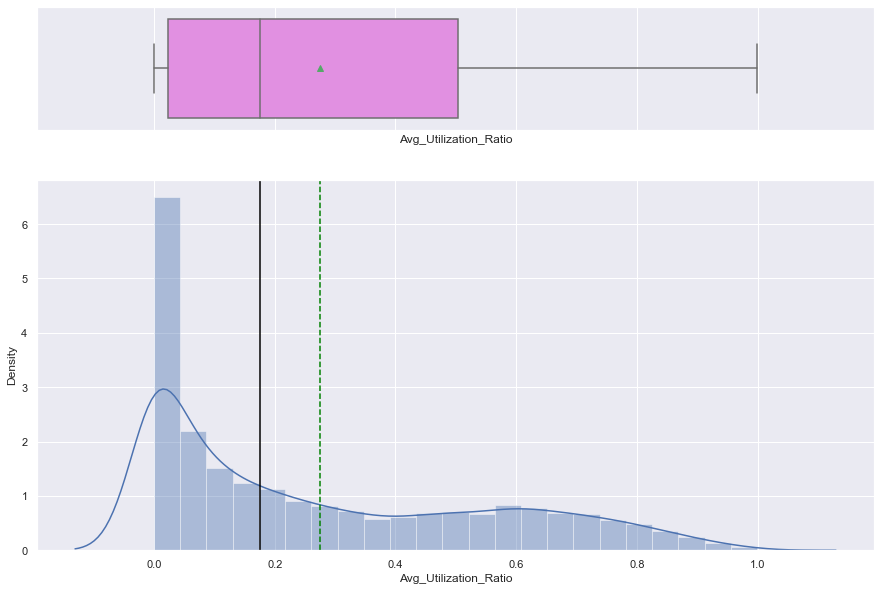

In [722]:
histogram_boxplot(data['Avg_Utilization_Ratio'])
data['Avg_Utilization_Ratio'].describe()

In [723]:
data['Avg_Utilization_Ratio'].nunique()

964

In [724]:
data['Avg_Utilization_Ratio'].value_counts()

0.000    2470
0.073      44
0.057      33
0.048      32
0.060      30
         ... 
0.335       1
0.985       1
0.949       1
0.818       1
0.972       1
Name: Avg_Utilization_Ratio, Length: 964, dtype: int64

In [725]:
if interactive_charts:
    fig = px.box(data['Avg_Utilization_Ratio'], orientation='h', height = 200)
    fig.show()

#### Avg_Utilization_Ratio (dtype: float)
* No outliers but data set is right skewed (mean > median)
* 964 unique values
* Large no of rows at 0 (2470 rows)
    * possible approach create a new feature = 1 where
    row is zero and 0 otherwise


#### 2-A (10) Total_Ct_Chng_Q4_Q1

count    10127.000000
mean         0.712222
std          0.238086
min          0.000000
25%          0.582000
50%          0.702000
75%          0.818000
max          3.714000
Name: Total_Ct_Chng_Q4_Q1, dtype: float64

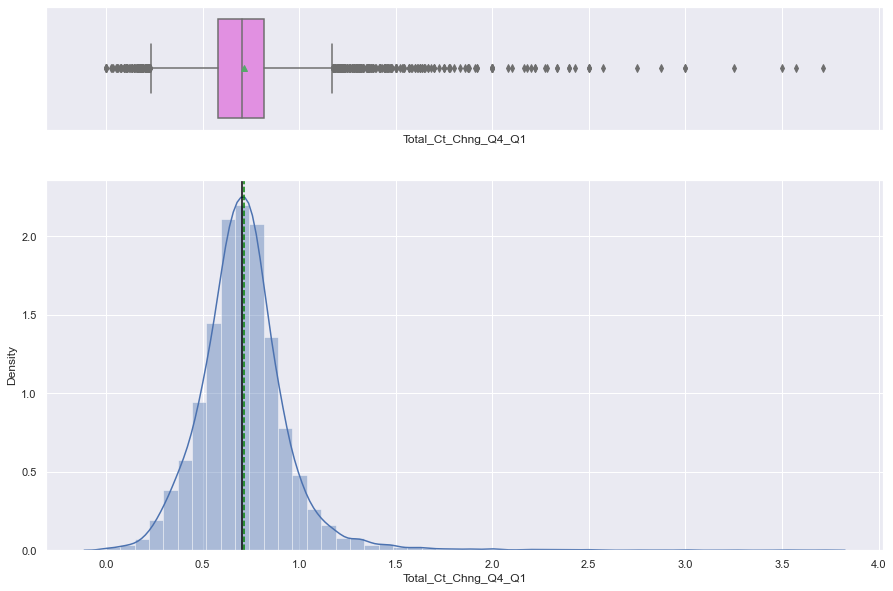

In [726]:
histogram_boxplot(data['Total_Ct_Chng_Q4_Q1'])
data['Total_Ct_Chng_Q4_Q1'].describe()

In [727]:
data['Total_Ct_Chng_Q4_Q1'].nunique()

830

In [728]:
data['Total_Ct_Chng_Q4_Q1'].value_counts()

0.667    171
1.000    166
0.500    161
0.750    156
0.600    113
        ... 
0.859      1
2.083      1
0.473      1
1.075      1
1.074      1
Name: Total_Ct_Chng_Q4_Q1, Length: 830, dtype: int64

In [729]:
if interactive_charts:
    fig = px.box(data['Total_Ct_Chng_Q4_Q1'], orientation='h', height = 200)
    fig.show()

#### Total_Ct_Chng_Q4_Q1 (dtype: float)
* quite a few outliers but very little skew (mean ~= median)
* 830 unique values
* possibly could normalise or cap

## 2-B Univariate analysis
* Now we examine categorical - numeric and non numeric cols

#### 2-B (11) Total_Relationship_Count

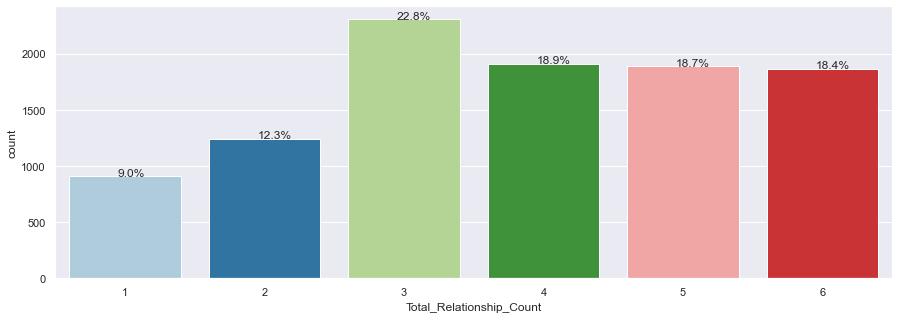

count    10127.000000
mean         3.812580
std          1.554408
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: Total_Relationship_Count, dtype: float64

In [730]:
perc_on_bar('Total_Relationship_Count')
data['Total_Relationship_Count'].describe()

In [731]:
data['Total_Relationship_Count'].nunique()

6

In [732]:
data['Total_Relationship_Count'].value_counts()


3    2305
4    1912
5    1891
6    1866
2    1243
1     910
Name: Total_Relationship_Count, dtype: int64

#### Total_Relationship_Count (dtype: int)
* 3 is the modal value followed by 4,5,6 approximately equal percentage wise
* 6 unique values
* reasonably uniform - no need to treat

#### 2-B (12) Dependent_count

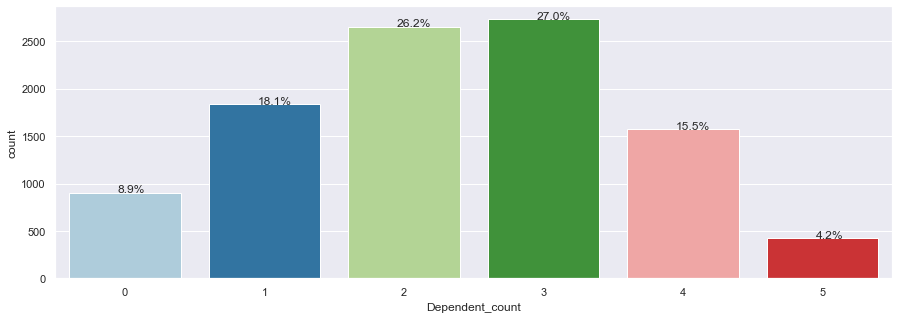

count    10127.000000
mean         2.346203
std          1.298908
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: Dependent_count, dtype: float64

In [733]:
perc_on_bar('Dependent_count')
data['Dependent_count'].describe()

In [734]:
data['Dependent_count'].nunique()

6

In [735]:
data['Dependent_count'].value_counts()

3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64

#### Dependent_count (dtype: int)
* 2 and 3 are the highest frequency of appearance (seems to be correlated with Total_Relationship_Count but
    there is no real relationship between features - have to be careful of false apparent corr)
* 6 unique values
* reasonably uniform - no need to treat

#### 2-B (13) Months_Inactive_12_mon

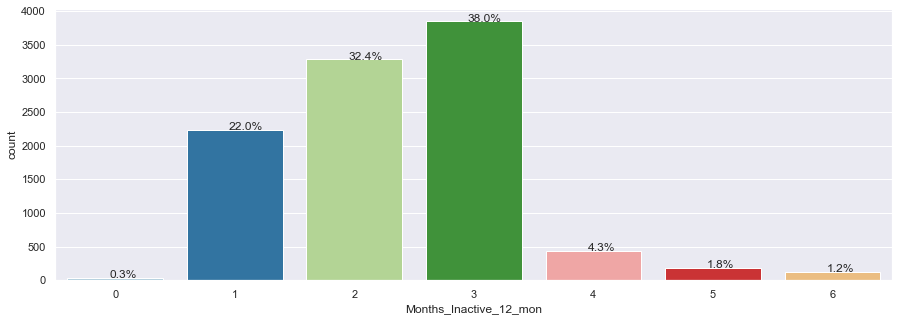

count    10127.000000
mean         2.341167
std          1.010622
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Months_Inactive_12_mon, dtype: float64

In [736]:
perc_on_bar('Months_Inactive_12_mon')
data['Months_Inactive_12_mon'].describe()

In [737]:
data['Months_Inactive_12_mon'].nunique()

7

In [738]:
data['Months_Inactive_12_mon'].value_counts()

3    3846
2    3282
1    2233
4     435
5     178
6     124
0      29
Name: Months_Inactive_12_mon, dtype: int64

#### Months_Inactive_12_mon (dtype: int)
* 3, 2 and 1 have highest frequency of appearance in descending order
* 7 unique values
* very few zero values - Some skewness in such data is understandable but will merge 0 values with 1


#### 2-B (14) Contacts_Count_12_mon

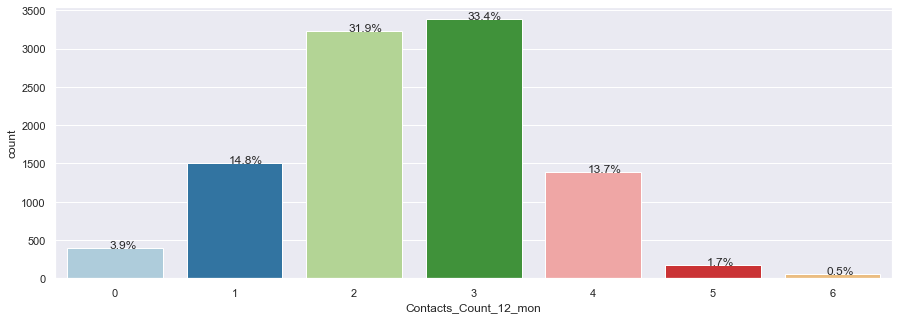

count    10127.000000
mean         2.455317
std          1.106225
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Contacts_Count_12_mon, dtype: float64

In [739]:
perc_on_bar('Contacts_Count_12_mon')
data['Contacts_Count_12_mon'].describe()

In [740]:
data['Contacts_Count_12_mon'].nunique()

7

In [741]:
data['Contacts_Count_12_mon'].value_counts()

3    3380
2    3227
1    1499
4    1392
0     399
5     176
6      54
Name: Contacts_Count_12_mon, dtype: int64

#### Contacts_Count_12_mon (dtype: int)
* 3, 2 and 1 have highest frequency of appearance in descending order
* 7 unique values
* very few 6 values - can probably merge with 5 to reduce dimensionality (post one hot encoding)


#### 2-B (15) Card_Category

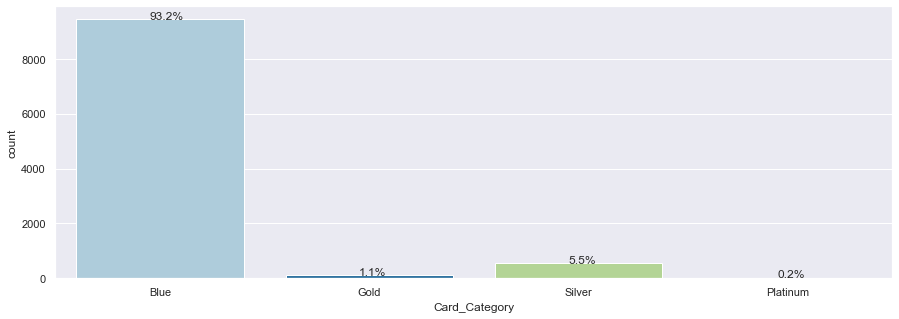

count     10127
unique        4
top        Blue
freq       9436
Name: Card_Category, dtype: object

In [742]:
perc_on_bar('Card_Category')
data['Card_Category'].describe()


In [743]:
data['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

#### Card_Category (dtype: object)
* Overwhelming number of Blue cards - 9436 rows
    * very few other categories
* This is ordinal so can replace as Blue = 0, Silver = 1, Gold = 2, Platinum = 3 (going by how usually such tiers
    are defined)
* May need to engineer into a new feature = 1 if Blue and 0 if not

#### 2-B (16) Income_Category

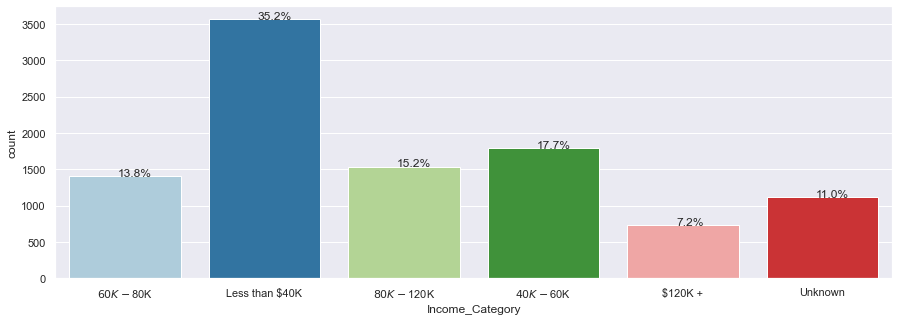

count              10127
unique                 6
top       Less than $40K
freq                3561
Name: Income_Category, dtype: object

In [744]:
perc_on_bar('Income_Category')
data['Income_Category'].describe()

In [745]:
data['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

#### Income_Category (dtype: object)
* Less than 40L is highest at 35% - reasonable distributed data among all other categories
* Unknown needs to be managed - will set as NaN after doing replace as below and using KNN to impute
* This is ordinal so can replace as Less than 40K = 0, 40-60 = 1, 60-80 = 2, 80-120 = 3, 120+ = 4, Unknown - NaN


#### 2-B (17) Marital_Status

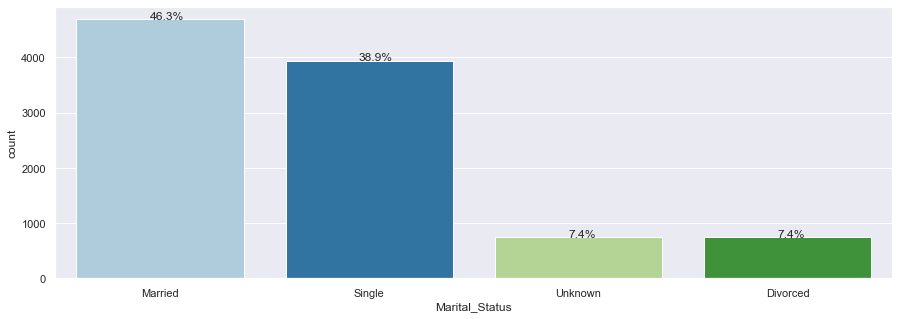

count       10127
unique          4
top       Married
freq         4687
Name: Marital_Status, dtype: object

In [746]:
perc_on_bar('Marital_Status')
data['Marital_Status'].describe()

In [747]:
data['Marital_Status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

#### Marital_Status (dtype: object)
* Married highest followed by Single
* Unknown needs to be managed - will set to modal value or examine other methods
* Cannot be set as ordinal - will need to see if correlated with other features -> in which case can use that
    relationship to replace unknowns

#### 2-B (18) Education_Level

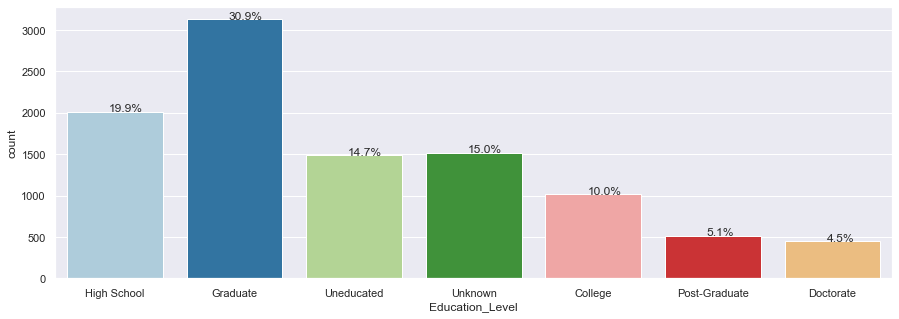

count        10127
unique           7
top       Graduate
freq          3128
Name: Education_Level, dtype: object

In [748]:
perc_on_bar('Education_Level')
data['Education_Level'].describe()

In [749]:
data['Education_Level'].value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

#### Education_Level (dtype: object)
* Graduates followed by High School are highest frequency
* Unknown needs to be managed - will set as NaN after doing replace as below and using KNN to impute
* graduate and college can be set to the same name
* This is ordinal so can replace as uneducated = 0, high school = 1, graduate/ college = 2, post grad = 3,
    doctorate = 4, Unknown - NaN

#### 2-B (19) Gender

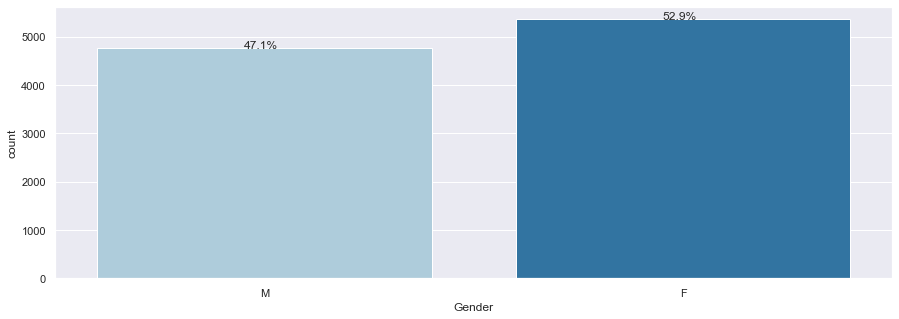

count     10127
unique        2
top           F
freq       5358
Name: Gender, dtype: object

In [750]:
perc_on_bar('Gender')
data['Gender'].describe()

In [751]:
data['Gender'].value_counts()

F    5358
M    4769
Name: Gender, dtype: int64

#### Gender (dtype: object)
* More females than males


#### 2-B (20) Attrition_Flag

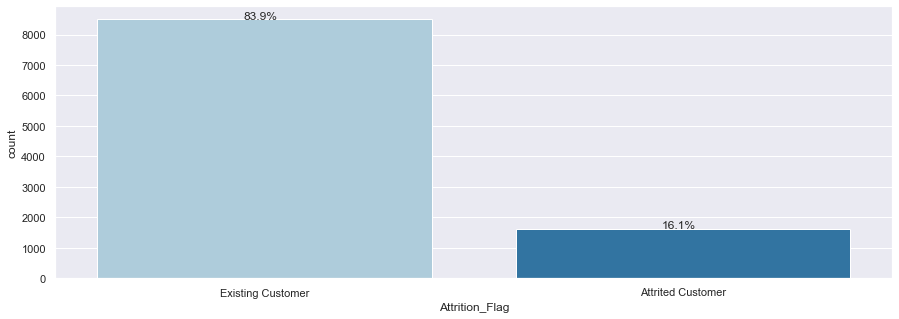

count                 10127
unique                    2
top       Existing Customer
freq                   8500
Name: Attrition_Flag, dtype: object

In [752]:
perc_on_bar('Attrition_Flag')
data['Attrition_Flag'].describe()

In [753]:
data['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

#### Attrition_Flag (dtype: object)
* Attrited is minority value in target feature
* will need to code this as Existing = 1, Attrited = 0 to use in model

## Encoding Categorical

In [754]:
working_df = data.copy()

In [755]:
## Encoding Categorical Ordinal Variables
Card_Category_d = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}
working_df['Card_Category']=working_df['Card_Category'].map(Card_Category_d).astype('Int32')

Income_Category_d = {'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +': 4,
                     'Unknown': np.nan}
working_df['Income_Category']=working_df['Income_Category'].map(Income_Category_d).astype('Int32')

Marital_Status_d = {'Single':0, 'Married':1, 'Divorced':2, 'Unknown':np.nan}
working_df['Marital_Status']=working_df['Marital_Status'].map(Marital_Status_d).astype('Int32')

Education_Level_d = {'Uneducated':0, 'High School':1, 'Graduate':2, 'College':2, 'Post-Graduate':3,
                     'Doctorate':4, 'Unknown': np.nan}
working_df['Education_Level']=working_df['Education_Level'].map(Education_Level_d).astype('Int32')

Gender_d = {'M':0, 'F':1}
working_df['Gender']=working_df['Gender'].map(Gender_d).astype('Int32')

Attrition_Flag_d = {'Existing Customer':0, 'Attrited Customer':1}
working_df['Attrition_Flag']=working_df['Attrition_Flag'].map(Attrition_Flag_d).astype('Int32')

working_df

Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
0                   0            45       0                3                1   
1                   0            49       1                5                2   
2                   0            51       0                3                2   
3                   0            40       1                4                1   
4                   0            40       0                3                0   
...               ...           ...     ...              ...              ...   
10122               0            50       0                2                2   
10123               1            41       0                2             <NA>   
10124               1            44       1                1                1   
10125               1            30       0                2                2   
10126               1            43       1                2                2   

       Marital_Status  Income_Category  Card_Category  Months_on_book  \
0                   1                2              0              39   
1                   0                0              0              44   
2                   1                3              0              36   
3                <NA>                0              0              34   
4                   1                2              0              21   
...               ...              ...            ...             ...   
10122               0                1              0              40   
10123               2                1              0              25   
10124               1                0              0              36   
10125            <NA>                1              0              36   
10126               1                0              1              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10122           2152.0                 0.703            15476             11

## Bivariate analysis [FIRST DO CAT ENCODING]

In [756]:
#for col in sd['categorical_cols']:
#    perc_on_bar(col)

CPU times: user 490 ms, sys: 63.1 ms, total: 553 ms
Wall time: 332 ms


<AxesSubplot:>

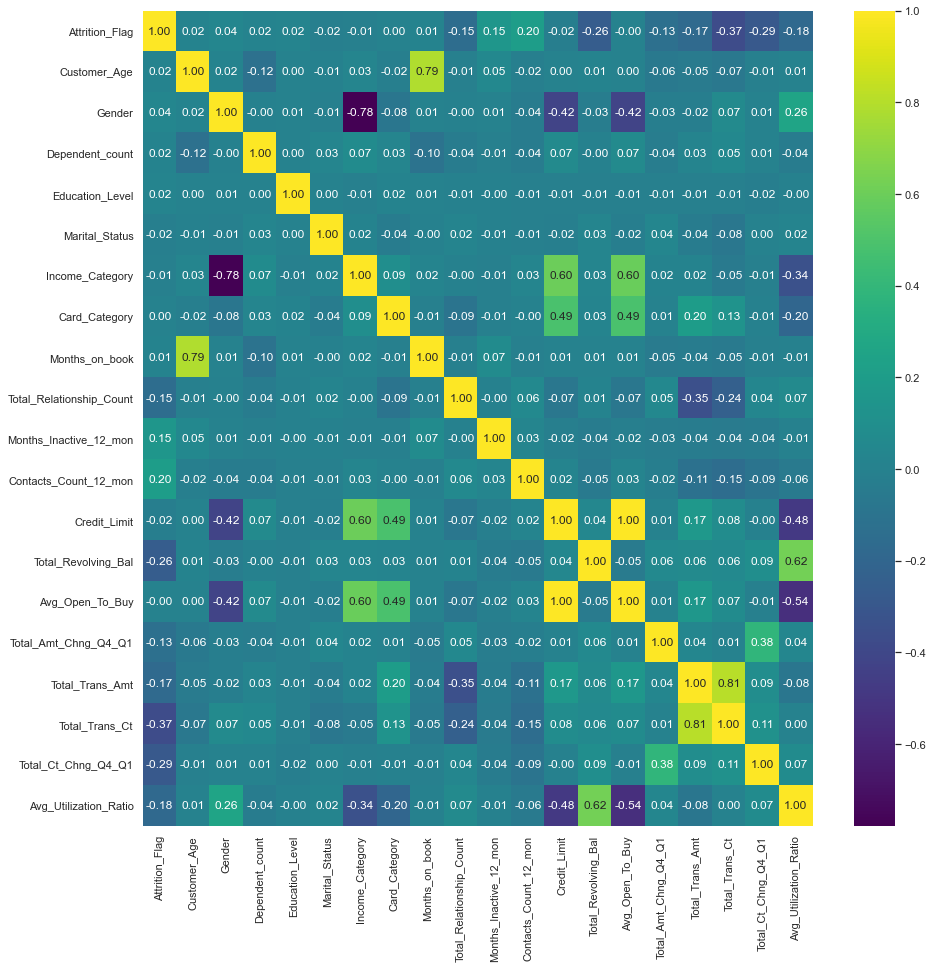

In [757]:
%%time
plt.figure(figsize=(15,15))
sns.heatmap(working_df.corr(), cmap='viridis', annot=True, fmt='.2f')

* High positive correlation for:
    * Avg_Open_To_Buy and Credit_Limit (1.00)
        * using def here: https://www.merchantservicesnewjersey.com/definitions/open-to-buy/
        * makes sense that these two would be highly corr
        * Will drop one of these
    * Total_Trans_Amt and Total_Trans_ct (0.81) - makes sense that higher number of tx will corr with higher quantum of tx
        * will consider dropping one
    * Months_on_book and Customer_Age (0.79) - makes sense to have high corr here
        * will consider dropping one
    * Total_Revolving_Balance and Avg_Utilixation_Ratio (0.62) - not high enough to drop one, again intuitively makes sense to have corr here
    *  Avg_Open_To_Buy and Income_Category (0.60) - not high enough to drop one, again intuitively makes sense to have corr here
* High negative correlation for:
    * Income_Category and Gender (-0.78) - women encoded as 1 and women in this dataset earn less than men
        * while the relationship does exist, we retain both

In [758]:
%%time
#sns.pairplot(data, hue='Attrition_Flag')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


* From the pairplot we can see there are differences in the distributions of variables with Attrited_Flag -> examined
below

#### Further bivariate investigation for non categorical columns

In [759]:
means_by_target = working_df.loc[:,numeric_non_cat_cols+['Attrition_Flag']].groupby('Attrition_Flag').mean()
median_by_target = working_df.loc[:,numeric_non_cat_cols+['Attrition_Flag']].groupby('Attrition_Flag').median()
print("mean vs. target:")
display(means_by_target)
print("median vs. target:")
display(median_by_target)

mean vs. target:


Customer_Age  Total_Trans_Ct  Total_Trans_Amt  \
Attrition_Flag                                                  
0                  46.262118       68.672588      4654.655882   
1                  46.659496       44.933620      3095.025814   

                Total_Revolving_Bal  Months_on_book  Total_Amt_Chng_Q4_Q1  \
Attrition_Flag                                                              
0                       1256.604118       35.880588              0.772510   
1                        672.822987       36.178242              0.694277   

                Avg_Open_To_Buy  Credit_Limit  Avg_Utilization_Ratio  \
Attrition_Flag                                                         
0                   7470.273400   8726.877518               0.296412   
1                   7463.216472   8136.039459               0.162475   

                Total_Ct_Chng_Q4_Q1  
Attrition_Flag                       
0                          0.742434  
1                          0.554386

median vs. target:


Customer_Age  Total_Trans_Ct  Total_Trans_Amt  \
Attrition_Flag                                                  
0                         46              71             4100   
1                         47              43             2329   

                Total_Revolving_Bal  Months_on_book  Total_Amt_Chng_Q4_Q1  \
Attrition_Flag                                                              
0                              1364              36                 0.743   
1                                 0              36                 0.701   

                Avg_Open_To_Buy  Credit_Limit  Avg_Utilization_Ratio  \
Attrition_Flag                                                         
0                        3469.5        4643.5                  0.211   
1                        3488.0        4178.0                  0.000   

                Total_Ct_Chng_Q4_Q1  
Attrition_Flag                       
0                             0.721  
1                             0.531

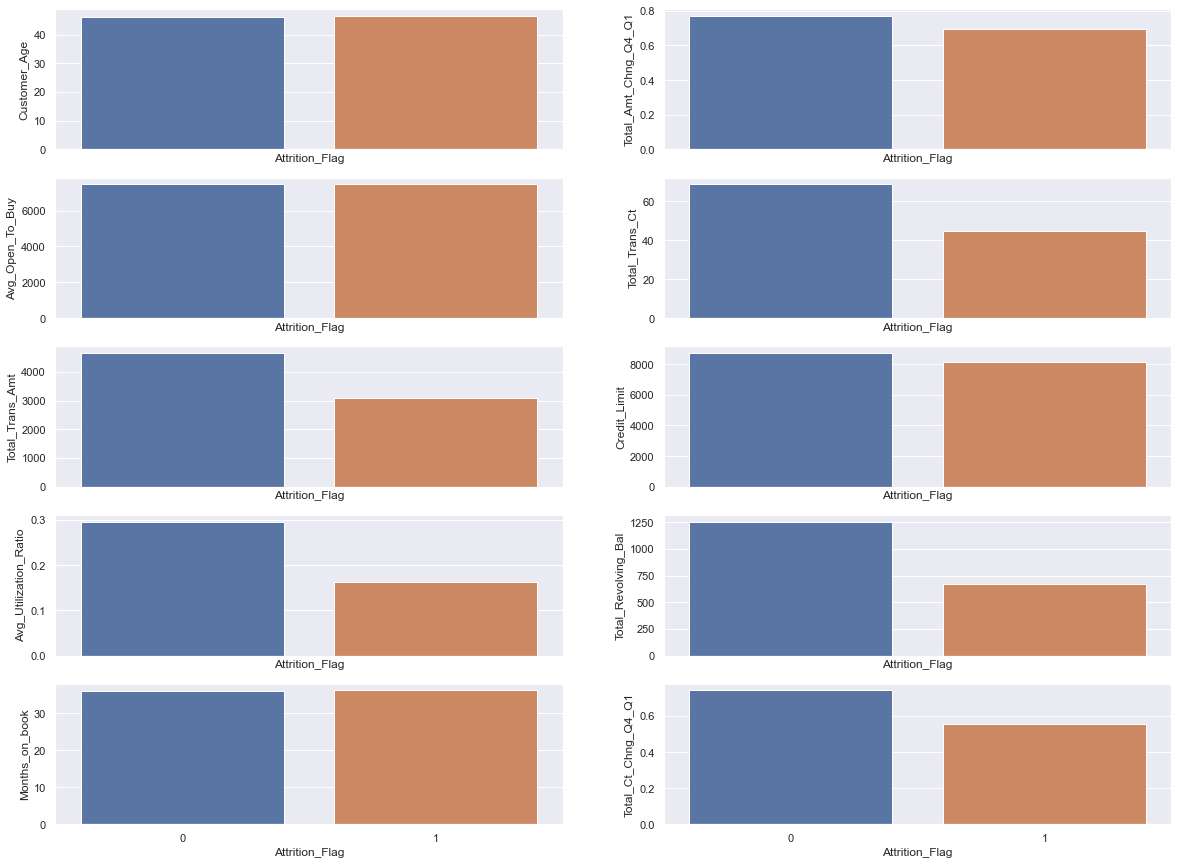

In [760]:
fig, ax = plt.subplots(5,2,figsize=(20,15), sharex=True)

for i,col in enumerate(means_by_target.columns):
    sns.barplot(x=means_by_target.index, y=means_by_target[col], ax=ax[i%5,i%2])

### Numeric Variables with Target
* Against the target the following features have clear patterns:
    1. **Total_Trans_Amt**: mean of 4655 for existing vs 3095 for attrited customers
        * Makes sense that attrited customers would've have not conducted as many tx

    2. **Total_Trans_Ct**: mean of 68.7 vs 44.9 for existing vs attrited customers
        * Again makes sense and we also found high corr b/w this feature and Tx amt

    3. **Avg_Utilization_Ratio**: mean of 0.30 vs 0.16 for existing vs attrited customer
        * makes sense that customers who left wouldve been using the card much less

    4. **Total_Revolving_Balance**: mean of 1257 vs 673 for existing vs attrited customers
        * makes sense here too that customers who left wouldve been using the card much less

    5. **Total_Ct_Chng_Q4_Q1**: mean of 0.72 vs 0.53 for existing vs attrited customers
        * The overall mean for this feature is 0.71 and median of 0.70; probably since attrited customers are
        not using the card as much, the drop in transaction count from Q4 to Q1 isnt as high an absolute number
        * This seems to be percentage change rather than absolute number (since units are same as AmtChng)

    6. **Total_Amt_Chng_Q4_Q1**: mean of 0.77 vs 0.69 for existing vs attrited customers
        * The overall mean for this feature is 0.76 and median of 0.74; probably since attrited customers are
        not using the card as much, the drop in transaction amt from Q4 to Q1 isnt as high an absolute number
        * This seems to be percentage change rather than absolute number 
        
    7. **Credit_Limit**: mean of 8727 vs 8136 for existing vs attrited customer
        * Makes sense that customers with higher credit limits are more likely to continue

* As against the above:
    * **Customer_Age** is not significantly corr with the target

#### Further bivariate investigation for categorical columns

In [761]:
for col in categorical_cols[:-1]:
    display(pd.crosstab(data['Attrition_Flag'],data[col], normalize='columns'))

Total_Relationship_Count         1         2         3         4         5  \
Attrition_Flag                                                               
Attrited Customer         0.256044  0.278359  0.173536  0.117678  0.120042   
Existing Customer         0.743956  0.721641  0.826464  0.882322  0.879958   

Total_Relationship_Count         6  
Attrition_Flag                      
Attrited Customer         0.105038  
Existing Customer         0.894962

Dependent_count           0         1         2         3         4         5
Attrition_Flag                                                               
Attrited Customer  0.149336  0.146355  0.157062  0.176428  0.165184  0.150943
Existing Customer  0.850664  0.853645  0.842938  0.823572  0.834816  0.849057

Months_Inactive_12_mon         0         1        2         3         4  \
Attrition_Flag                                                            
Attrited Customer       0.517241  0.044783  0.15387  0.214769  0.298851   
Existing Customer       0.482759  0.955217  0.84613  0.785231  0.701149   

Months_Inactive_12_mon         5         6  
Attrition_Flag                              
Attrited Customer       0.179775  0.153226  
Existing Customer       0.820225  0.846774

Contacts_Count_12_mon         0         1         2         3         4  \
Attrition_Flag                                                            
Attrited Customer      0.017544  0.072048  0.124884  0.201479  0.226293   
Existing Customer      0.982456  0.927952  0.875116  0.798521  0.773707   

Contacts_Count_12_mon         5    6  
Attrition_Flag                        
Attrited Customer      0.335227  1.0  
Existing Customer      0.664773  0.0

Card_Category          Blue      Gold  Platinum    Silver
Attrition_Flag                                           
Attrited Customer  0.160979  0.181034      0.25  0.147748
Existing Customer  0.839021  0.818966      0.75  0.852252

Income_Category     $120K +  $40K - $60K  $60K - $80K  $80K - $120K  \
Attrition_Flag                                                        
Attrited Customer  0.173315     0.151397     0.134807      0.157655   
Existing Customer  0.826685     0.848603     0.865193      0.842345   

Income_Category    Less than $40K   Unknown  
Attrition_Flag                               
Attrited Customer        0.171862  0.168165  
Existing Customer        0.828138  0.831835

Marital_Status     Divorced   Married    Single  Unknown
Attrition_Flag                                          
Attrited Customer  0.161765  0.151269  0.169414  0.17223
Existing Customer  0.838235  0.848731  0.830586  0.82777

Education_Level     College  Doctorate  Graduate  High School  Post-Graduate  \
Attrition_Flag                                                                 
Attrited Customer  0.152024   0.210643  0.155691     0.152012       0.178295   
Existing Customer  0.847976   0.789357  0.844309     0.847988       0.821705   

Education_Level    Uneducated   Unknown  
Attrition_Flag                           
Attrited Customer    0.159381  0.168532  
Existing Customer    0.840619  0.831468

Gender                    F         M
Attrition_Flag                       
Attrited Customer  0.173572  0.146152
Existing Customer  0.826428  0.853848

Total_Relationship_Count


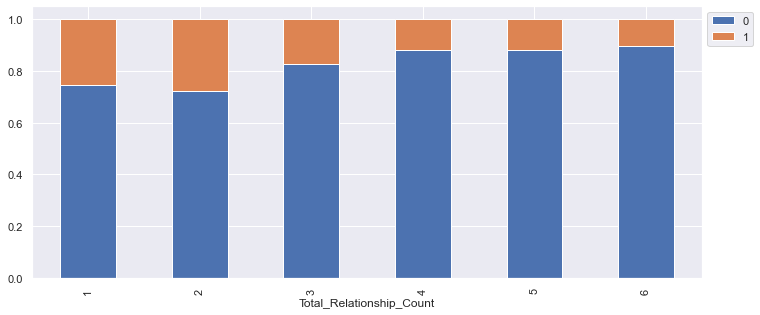

Dependent_count


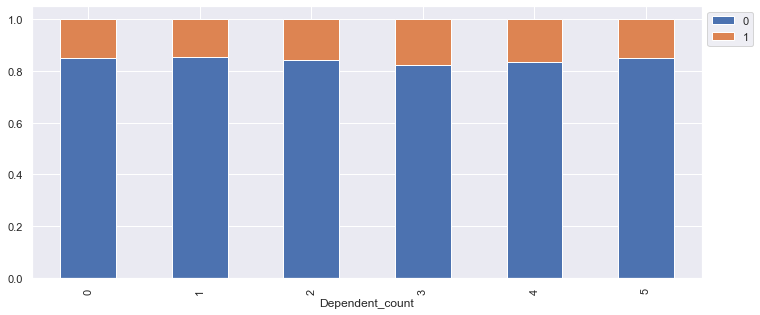

Months_Inactive_12_mon


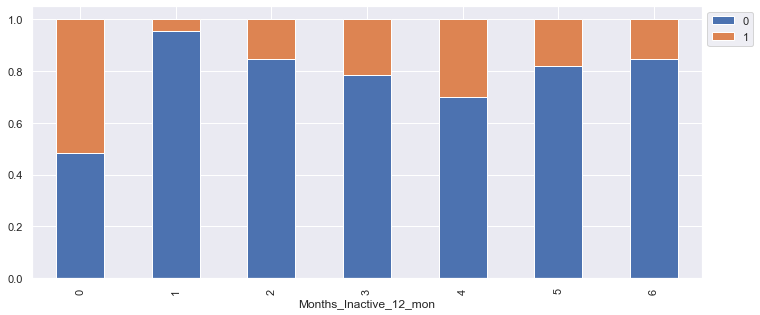

Contacts_Count_12_mon


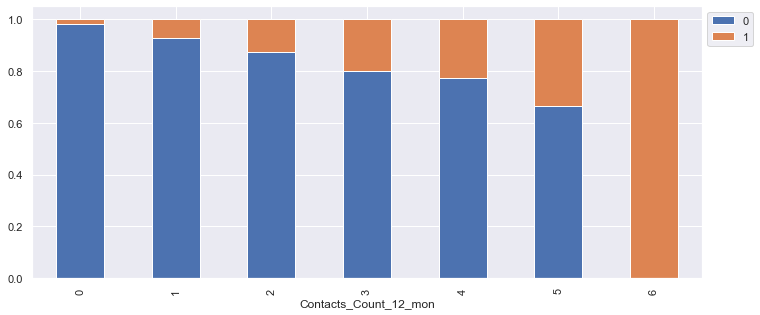

Card_Category


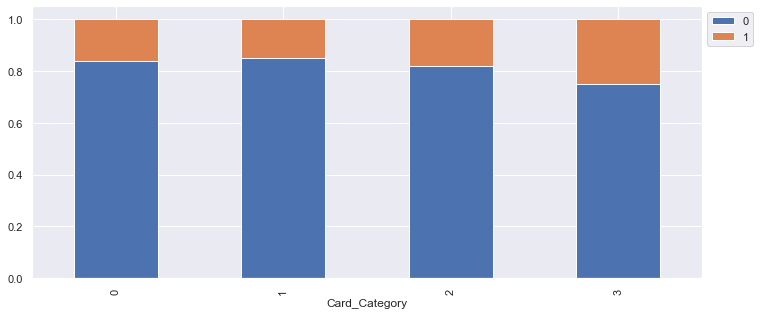

Income_Category


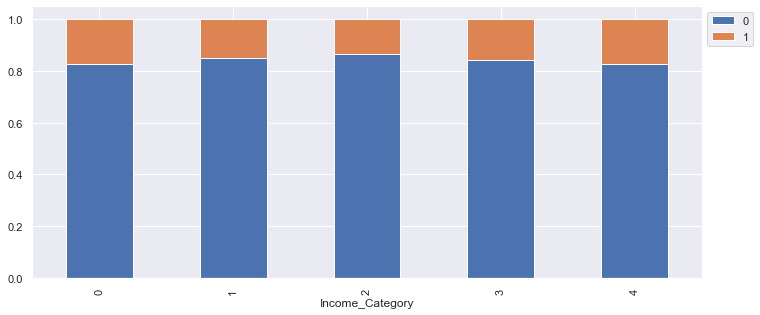

Marital_Status


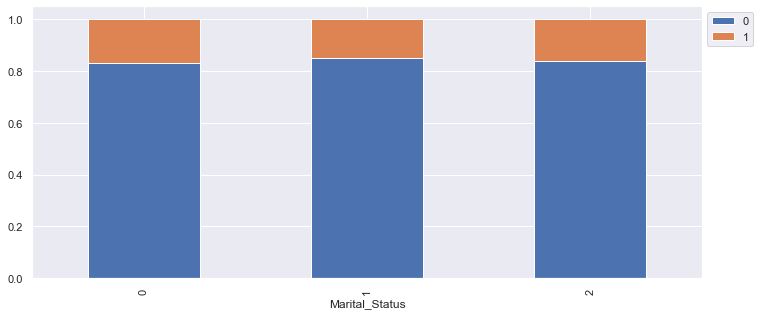

Education_Level


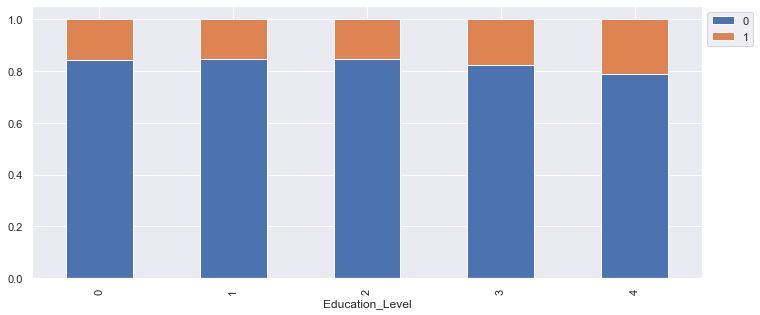

Gender


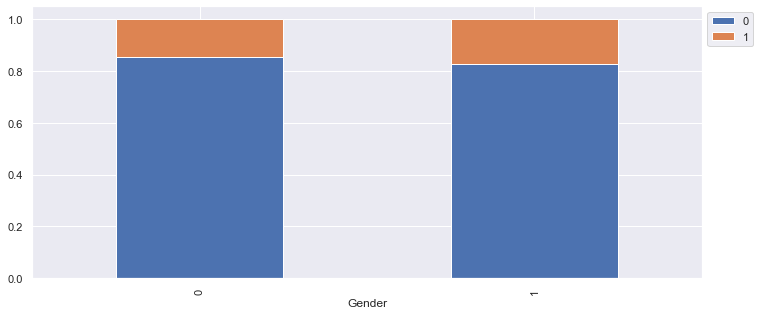

In [762]:
#fig, ax = plt.subplots(5,2,figsize=(20,15), sharex=True)

for i,col in enumerate(categorical_cols[:-1]):
    print(col)
    stacked_plot(col, 'Attrition_Flag', working_df)
    #sns.barplot(x=means_by_target.index, y=means_by_target[col], ax=ax[i%5,i%2])

#### Categorical Variables with Target
1. Total_Relationship_Count
    - With higher number of relationships with the bank, the customer is less likely to attrition 
    - Makes sense as the customer would be more invested with the bank and cross-selling is a long accepted best practice in the banking industry
2. Dependent_Count
    - Generally with higher number of dependents, attrition likelihood increases slightly except for dependents = 5 where it drops 
3. Months_Inactive_12_mon
    - We can ignore the 0 column as there are only 0.3% rows with 0 Months_Inactive_12_mon
    - For the other columns, attrition increases as months of inactivity increases (5 and 6 months show a slight increase but again there are only ~1.5% rows each for those values - not significant enough to draw trends)
4. Contacts_Count_12_mon
    - As contacts increase, attrition increases up to 3 months but then there is a sharp drop from 3 to 4 and 4 to 5
    - 6 months is 100% attrition but only 0.5% rows have 6 months so too small to infer trends
5. Card Category
    - Higher ranked cards are more likely to attrition than Blue card holders. However there are very few customers with Gold/ Silver/ Platinum and so to reduce dimensionality we will reduce this feature to a binary based on if is or not Blue
6. Income Category
    - No clear trends here
7. Marital Status
    - No significant trends vs target
8. Gender
    - Sightly higher chance of attriting for Females (17.4% females attrited vs. 14.6% males)
9. Education_Level
    - Higher probability of attriting with higher education levels - possibly

<AxesSubplot:xlabel='Gender', ylabel='Total_Trans_Amt'>

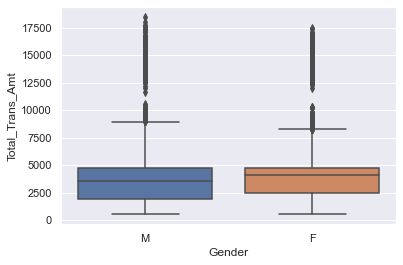

In [763]:
sns.boxplot(y=data['Total_Trans_Amt'], x=data['Gender'])




### 3A Dropping Columns, Splitting Train/ Test Sets 

In [764]:
cols_to_drop = ['Avg_Open_To_Buy']

model_df = working_df.drop(cols_to_drop, axis =1)

X = model_df.drop(columns='Attrition_Flag')
Y = model_df['Attrition_Flag'].astype('float64')

X_train_temp, X_test_temp, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=random_state, stratify=Y)
print(X_train_temp.shape, X_test_temp.shape)

(7088, 18) (3039, 18)


In [765]:
display(y_test.value_counts(normalize=True))
display(y_train.value_counts(normalize=True))


0.0    0.839421
1.0    0.160579
Name: Attrition_Flag, dtype: float64

0.0    0.839306
1.0    0.160694
Name: Attrition_Flag, dtype: float64

* Both train and test splits have 0.161 percentage of target =1 rows

### 3B Imputing Missing Values using KNN


In [766]:
imputer = KNNImputer(n_neighbors=5)

In [767]:
#Fit and transform the train data
X_train_temp = pd.DataFrame(imputer.fit_transform(X_train_temp),columns=X_train_temp.columns )

#Transform the test data 
X_test_temp=pd.DataFrame(imputer.transform(X_test_temp),columns=X_test_temp.columns )


In [768]:
#Checking that no column has missing values in train or test sets
print(X_train_temp.isna().sum())
print('-'*30)
print(X_test_temp.isna().sum())

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
------------------------------
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1      

* All missing values have been succesfully imputed using KNN 
* Imputer was fit only on train data, test data was only transformed (test data not used to fit imputer) - thus avoiding data leakage

### 3C Reverse Encoding Categorical Columns

In [769]:
## Function to inverse the encoding
def inverse_mapping(x,y, df_train, df_test):
    inv_dict = {v: k for k, v in x.items()}
    print(inv_dict)
    df_train[y] = np.round(df_train[y]).map(inv_dict).astype('category')
    df_test[y] = np.round(df_test[y]).map(inv_dict).astype('category')

In [770]:
X_train = X_train_temp.copy()
X_test = X_test_temp.copy()


inverse_mapping(Gender_d, 'Gender', X_train, X_test)
inverse_mapping(Education_Level_d, 'Education_Level', X_train, X_test)
inverse_mapping(Income_Category_d, 'Income_Category', X_train, X_test)
inverse_mapping(Card_Category_d, 'Card_Category', X_train, X_test)
inverse_mapping(Marital_Status_d, 'Marital_Status', X_train, X_test)



{0: 'M', 1: 'F'}
{0: 'Uneducated', 1: 'High School', 2: 'College', 3: 'Post-Graduate', 4: 'Doctorate', nan: 'Unknown'}
{0: 'Less than $40K', 1: '$40K - $60K', 2: '$60K - $80K', 3: '$80K - $120K', 4: '$120K +', nan: 'Unknown'}
{0: 'Blue', 1: 'Silver', 2: 'Gold', 3: 'Platinum'}
{0: 'Single', 1: 'Married', 2: 'Divorced', nan: 'Unknown'}


In [771]:
#Just setting all categorical 

In [772]:
X_train

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0             50.0      F              1.0         College        Married   
1             50.0      M              0.0     High School       Divorced   
2             26.0      F              0.0         College         Single   
3             65.0      F              0.0         College         Single   
4             46.0      M              3.0         College         Single   
...            ...    ...              ...             ...            ...   
7083          50.0      F              2.0         College        Married   
7084          56.0      M              0.0       Doctorate         Single   
7085          45.0      M              5.0      Uneducated         Single   
7086          35.0      M              0.0     High School         Single   
7087          41.0      F              4.0      Uneducated         Single   

     Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0        $40K - $60K          Blue            43.0                       6.0   
1        $60K - $80K          Blue            36.0                       3.0   
2        $40K - $60K          Blue            13.0                       6.0   
3     Less than $40K          Blue            55.0                       3.0   
4       $80K - $120K          Blue            35.0                       6.0   
...              ...           ...             ...                       ...   
7083  Less than $40K          Blue            36.0                       5.0   
7084    $80K - $120K          Blue            47.0                       2.0   
7085         $120K +        Silver            36.0                       4.0   
7086    $80K - $120K          Gold            29.0                       6.0   
7087  Less than $40K          Blue            32.0                       4.0   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                        1.0                    2.0        7985.0   
1                        3.0                    2.0        5444.0   
2                        3.0                    4.0        1643.0   
3                        3.0                    0.0        2022.0   
4                        3.0                    4.0        4930.0   
...                      ...                    ...           ...   
7083                     2.0                    2.0        1438.3   
7084                     1.0                    2.0        7204.0   
7085                     2.0                    1.0       34516.0   
7086                     2.0                    3.0       34516.0   
7087                     3.0                    1.0        3189.0   

      Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
0                     0.0                 1.032           3873.0   
1                  2499.0                 0.468           4509.0   
2                  1101.0                 0.713           2152.0   
3                     0.0                 0.579           4623.0   
4                     0.0                 1.019           3343.0   
...                   ...                   ...              ...   
7083                  0.0                 0.658           2329.0   
7084                  0.0                 0.803          14042.0   
7085                  0.0                 0.732           8603.0   
7086               1965.0                 1.044           2949.0   
7087                  0.0                 0.910           4813.0   

      Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0               72.0                0.674                  0.000  
1               80.0                0.667                  0.459  
2               50.0                0.471                  0.670  
3               65.0                0.548                  0.000  
4               77.0                0.638                  0.000  
...              ...                  ...                    ...  
7083 

In [773]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.shape, X_test.shape)

(7088, 27) (3039, 27)


### Logistic Regression 

In [774]:
lr = LogisticRegression(random_state=random_state)
lr.fit(X_train, y_train)

LogisticRegression(random_state=314159)

In [775]:
lr.score(X_train, y_train)
score_df = model_score_df(lr,X_train, y_train, X_test, y_test, 'LR')

In [776]:
score_df

LR-train   LR-test
model_accuracy                0.887133  0.885489
model_recall_sensitivity_TPR  0.449517  0.432377
model_precision               0.747445  0.748227
Specificity_TNR               0.970919  0.972168
model_f1                      0.561404  0.548052
FPR                           0.029081  0.027832

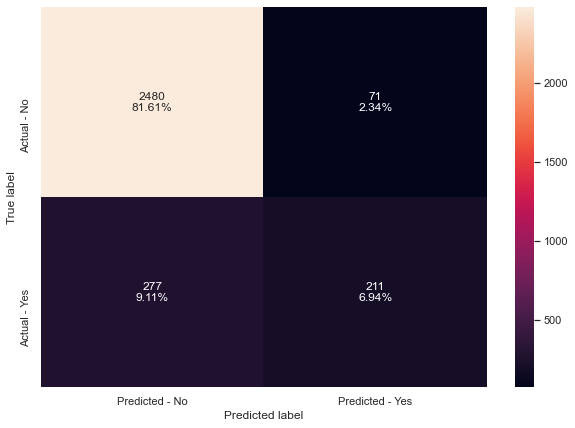

In [796]:
make_confusion_matrix(lr, y_test)

LogisticRegression(random_state=314159)


<AxesSubplot:>

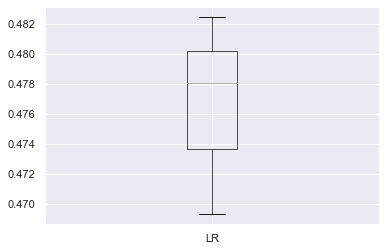

In [777]:
def kfolds(model, X_train, y_train, label, scoring='recall', results_df = None):
    
    print(model)
    kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)     #Setting number of splits equal to 5
    cv_result_bfr=cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold)

    df = pd.DataFrame(cv_result_bfr, columns=[label])
    #display(df)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.merge(results_df, df, left_index=True, right_index=True)

    return results_df


kfold_results_df = kfolds(lr, X_train, y_train, 'LR')
#print(results_df)
#Plotting boxplots for CV scores of model defined above
#fig = plt.figure(figsize=(15, 5))

'''fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()'''

kfold_results_df.boxplot()

In [797]:
print("recall scores:")
kfold_results_df

recall scores:


LR_x   LR-over  LR-under      LR_y     DTREE        RF       GBM  \
0  0.482456  0.842017  0.798246  0.530702  0.807018  0.780702  0.815789   
1  0.478070  0.863866  0.820175  0.662281  0.881579  0.864035  0.885965   
2  0.473684  0.849580  0.824561  0.539474  0.785088  0.802632  0.820175   
3  0.480176  0.846930  0.797357  0.621145  0.770925  0.779736  0.810573   
4  0.469298  0.819328  0.815789  0.574561  0.723684  0.767544  0.820175   

        ADB       XGB  
0  0.807018  0.877193  
1  0.903509  0.916667  
2  0.820175  0.855263  
3  0.841410  0.859031  
4  0.793860  0.850877

### Logistic Regression - Oversampling

In [798]:
from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=random_state)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 1139
Before UpSampling, counts of label 'No': 5949 

After UpSampling, counts of label 'Yes': 5949
After UpSampling, counts of label 'No': 5949 

After UpSampling, the shape of train_X: (11898, 27)
After UpSampling, the shape of train_y: (11898,) 



In [780]:
lr_over = LogisticRegression(random_state = random_state)

# Training the basic logistic regression model with training set 
lr_over.fit(X_train_over,y_train_over)
score_df = model_score_df(lr_over, X_train_over, y_train_over, X_test, y_test, 'LR-over', score_df)
score_df

LR-train   LR-test  LR-over-train  LR-over-test
model_accuracy                0.887133  0.885489       0.846697      0.826259
model_recall_sensitivity_TPR  0.449517  0.432377       0.855438      0.801230
model_precision               0.747445  0.748227       0.840740      0.475669
Specificity_TNR               0.970919  0.972168       0.837956      0.831047
model_f1                      0.561404  0.548052       0.848025      0.596947
FPR                           0.029081  0.027832       0.162044      0.168953

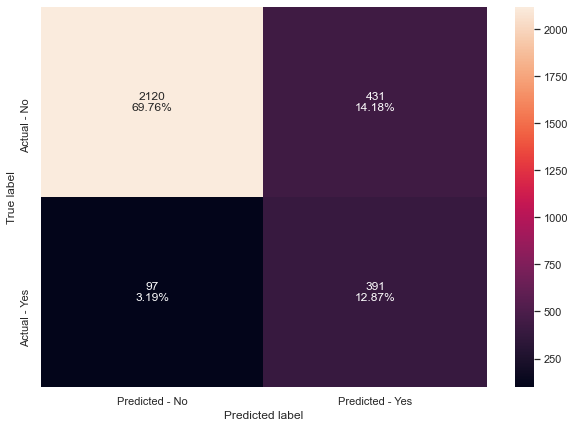

In [799]:
make_confusion_matrix(lr_over, y_test)

In [781]:
kfold_results_df = kfolds(lr_over, X_train_over, y_train_over, 'LR-over', results_df=kfold_results_df)


kfold_results_df


LogisticRegression(random_state=314159)


LR   LR-over
0  0.482456  0.842017
1  0.478070  0.863866
2  0.473684  0.849580
3  0.480176  0.846930
4  0.469298  0.819328

In [782]:
px.box(kfold_results_df, title='Recall Scores')

In [783]:
score_df

LR-train   LR-test  LR-over-train  LR-over-test
model_accuracy                0.887133  0.885489       0.846697      0.826259
model_recall_sensitivity_TPR  0.449517  0.432377       0.855438      0.801230
model_precision               0.747445  0.748227       0.840740      0.475669
Specificity_TNR               0.970919  0.972168       0.837956      0.831047
model_f1                      0.561404  0.548052       0.848025      0.596947
FPR                           0.029081  0.027832       0.162044      0.168953

<h1><font color=red> do regm

### Logistic Regression - Undersampling


In [784]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = random_state)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [785]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 1139
Before Under Sampling, counts of label 'No': 5949 

After Under Sampling, counts of label 'Yes': 1139
After Under Sampling, counts of label 'No': 1139 

After Under Sampling, the shape of train_X: (2278, 27)
After Under Sampling, the shape of train_y: (2278,) 



In [786]:
lr_under = LogisticRegression(random_state = random_state)
lr_under.fit(X_train_un,y_train_un )

score_df = model_score_df(lr_under, X_train_un, y_train_un, X_test, y_test, 'LR-under', score_df)
score_df

LR-train   LR-test  LR-over-train  LR-over-test  \
model_accuracy                0.887133  0.885489       0.846697      0.826259   
model_recall_sensitivity_TPR  0.449517  0.432377       0.855438      0.801230   
model_precision               0.747445  0.748227       0.840740      0.475669   
Specificity_TNR               0.970919  0.972168       0.837956      0.831047   
model_f1                      0.561404  0.548052       0.848025      0.596947   
FPR                           0.029081  0.027832       0.162044      0.168953   

                              LR-under-train  LR-under-test  
model_accuracy                      0.820457       0.803883  
model_recall_sensitivity_TPR        0.812994       0.795082  
model_precision                     0.825312       0.438914  
Specificity_TNR                     0.827919       0.805566  
model_f1                            0.819107       0.565598  
FPR                                 0.172081       0.194434

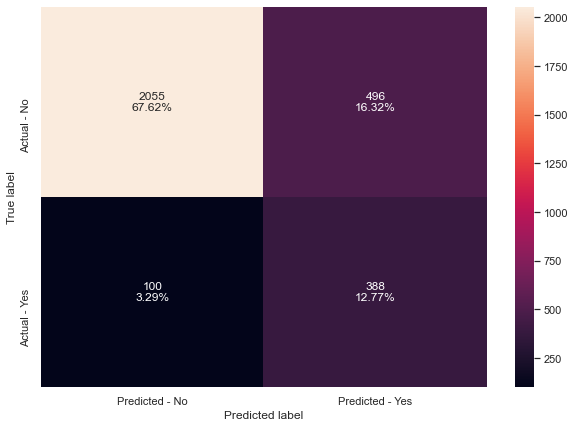

In [800]:
make_confusion_matrix(lr_under, y_test)

In [787]:
kfold_results_df = kfolds(lr_under, X_train_un, y_train_un, 'LR-under', results_df=kfold_results_df)


kfold_results_df

LogisticRegression(random_state=314159)


LR   LR-over  LR-under
0  0.482456  0.842017  0.798246
1  0.478070  0.863866  0.820175
2  0.473684  0.849580  0.824561
3  0.480176  0.846930  0.797357
4  0.469298  0.819328  0.815789

Comparing Recall Scores across models:


<AxesSubplot:>

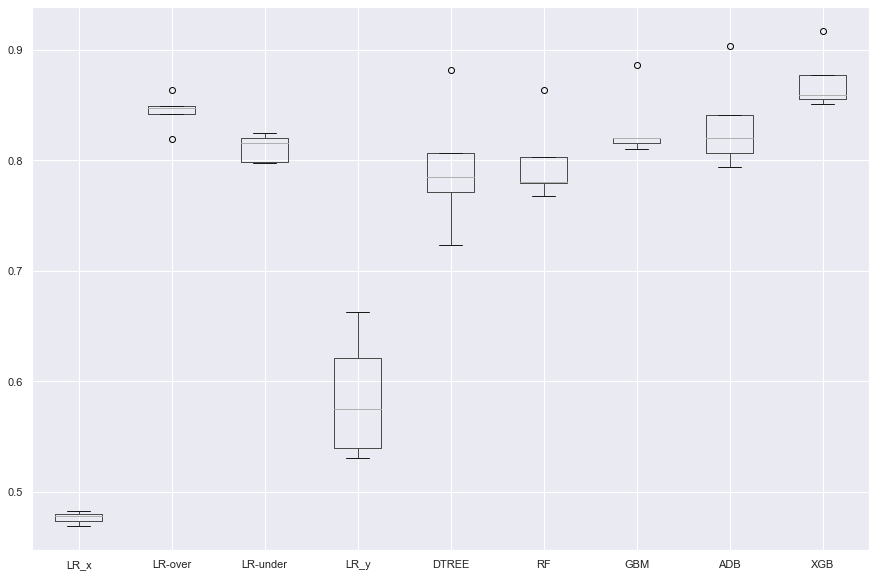

In [801]:
#px.box(kfold_results_df, orientation='h', width=1000)
#plt.figure(figsize=(15,10))
print('Comparing Recall Scores across models:')

kfold_results_df.boxplot(grid=True, figsize=(15,10))



### 4B Ensemble Methods

In [913]:
models = {
        "LR":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(random_state=random_state)),
            ]),
            
        "DT":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("dt", DecisionTreeClassifier(random_state=random_state)),
            ]),
        "RF":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("rf", RandomForestClassifier(random_state=random_state)),
            ]),
        "BG":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("bg", BaggingClassifier(random_state=random_state)),
            ]),
        "GBM":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gb", GradientBoostingClassifier(random_state=random_state)),
            ]),
        "ADB":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("ad", AdaBoostClassifier(random_state=random_state)),
            ]),
        "XGB":
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xg", XGBClassifier(random_state=random_state,eval_metric='logloss')),
            ])
}

models

{'LR': Pipeline(steps=[('scaler', StandardScaler()),
                 ('lr', LogisticRegression(random_state=314159))]),
 'DT': Pipeline(steps=[('scaler', StandardScaler()),
                 ('dt', DecisionTreeClassifier(random_state=314159))]),
 'RF': Pipeline(steps=[('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier(random_state=314159))]),
 'BG': Pipeline(steps=[('scaler', StandardScaler()),
                 ('bg', BaggingClassifier(random_state=314159))]),
 'GBM': Pipeline(steps=[('scaler', StandardScaler()),
                 ('gb', GradientBoostingClassifier(random_state=314159))]),
 'ADB': Pipeline(steps=[('scaler', StandardScaler()),
                 ('ad', AdaBoostClassifier(random_state=314159))]),
 'XGB': Pipeline(steps=[('scaler', StandardScaler()),
                 ('xg',
                  XGBClassifier(base_score=None, booster=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsa

In [831]:
%%time
score_df_step2 = pd.DataFrame()
for i,key in enumerate(models):
    model = models[key]
    model.fit(X_train, y_train)
    if i == 0:
        score_df_step2 = model_score_df(model, X_train, y_train, X_test, y_test, label=key, score_df = None)
    else:    
        score_df_step2 = model_score_df(model, X_train, y_train, X_test, y_test, label=key, score_df = score_df_step2)

score_df_step2

CPU times: user 9.28 s, sys: 356 ms, total: 9.63 s
Wall time: 3.65 s


LR-train   LR-test  DT-train   DT-test  \
model_accuracy                0.906462  0.899638       1.0  0.943731   
model_recall_sensitivity_TPR  0.592625  0.565574       1.0  0.846311   
model_precision               0.772311  0.747967       1.0  0.811395   
Specificity_TNR               0.966549  0.963544       1.0  0.962368   
model_f1                      0.670641  0.644107       1.0  0.828485   
FPR                           0.033451  0.036456       0.0  0.037632   

                              RF-train   RF-test  BG-train   BG-test  \
model_accuracy                     1.0  0.959855  0.996614  0.956236   
model_recall_sensitivity_TPR       1.0  0.813525  0.982441  0.844262   
model_precision                    1.0  0.927570  0.996438  0.878465   
Specificity_TNR                    1.0  0.987848  0.999328  0.977656   
model_f1                           1.0  0.866812  0.989390  0.861024   
FPR                                0.0  0.012152  0.000672  0.022344   

                              GBM-train  GBM-test  ADB-train  ADB-test  \
model_accuracy                 0.975875  0.967423   0.957816  0.956894   
model_recall_sensitivity_TPR   0.888499  0.872951   0.841967  0.852459   
model_precision                0.958333  0.920086   0.889610  0.875789   
Specificity_TNR                0.992604  0.985496   0.979997  0.976872   
model_f1                       0.922096  0.895899   0.865133  0.863967   
FPR                            0.007396  0.014504   0.020003  0.023128   

                              XGB-train  XGB-test  
model_accuracy                      1.0  0.972688  
model_recall_sensitivity_TPR        1.0  0.909836  
model_precision                     1.0  0.919255  
Specificity_TNR                     1.0  0.984712  
model_f1                            1.0  0.914521  
FPR                                 0.0  0.015288

Confusion Matrix for LR
Confusion Matrix for DT
Confusion Matrix for RF
Confusion Matrix for BG
Confusion Matrix for GBM
Confusion Matrix for ADB
Confusion Matrix for XGB


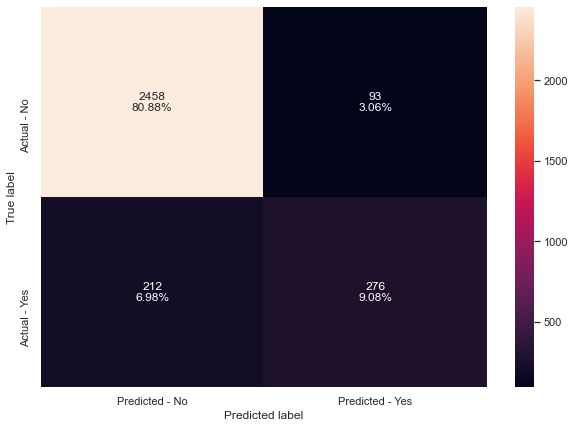

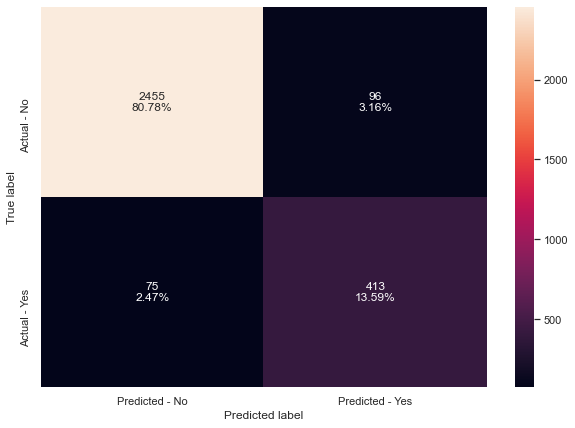

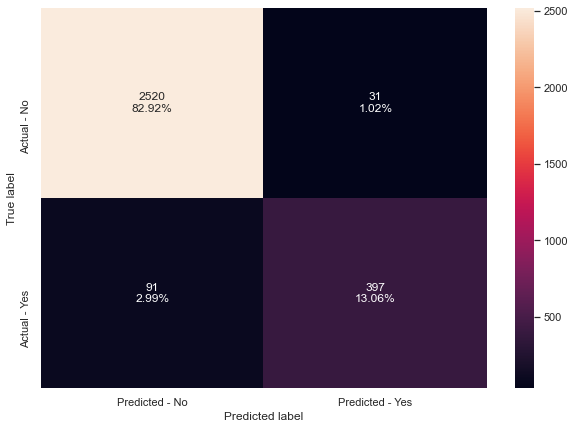

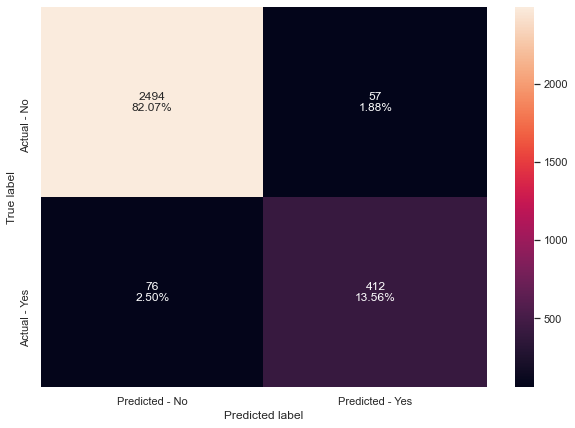

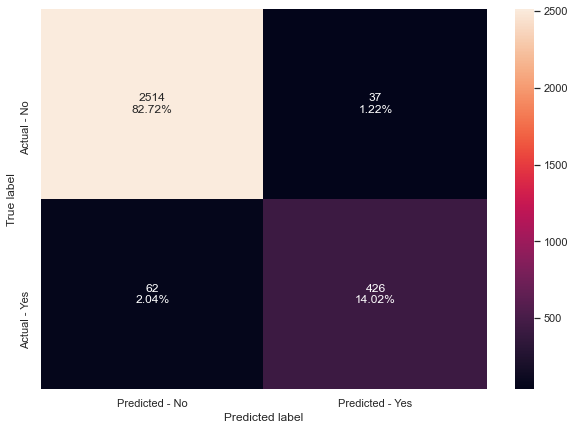

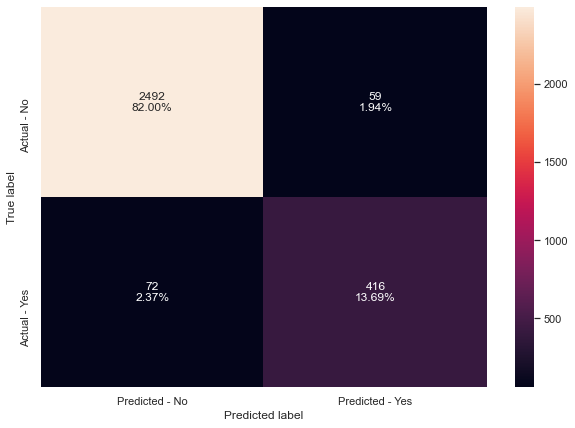

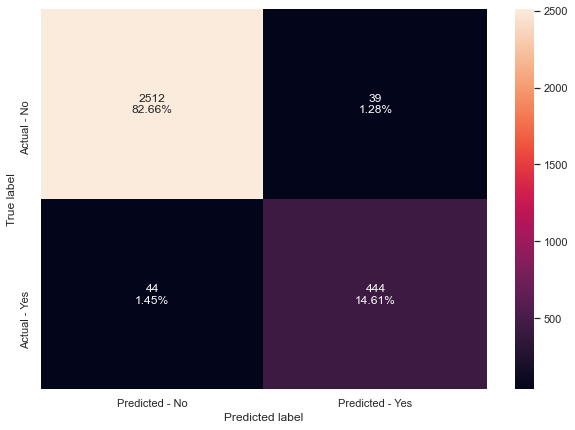

In [832]:
for key in models:
    print(f'Confusion Matrix for {key}')
    make_confusion_matrix(models[key], y_test)

In [834]:
%%time
kfold_results_step2 = pd.DataFrame()

for i,key in enumerate(models):
    model = models[key]
    if i==0:
        kfold_results_step2 = kfolds(model, X_train, y_train, key, results_df=None)
    else:    
        kfold_results_step2 = kfolds(model, X_train, y_train, key, results_df=kfold_results_step2)

kfold_results_step2


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('bg', BaggingClassifier(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('gb', GradientBoostingClassifier(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('ad', AdaBoostClassifier(random_state=314159))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('xg',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               ga

LR        DT        RF        BG       GBM       ADB       XGB
0  0.530702  0.807018  0.780702  0.824561  0.815789  0.807018  0.877193
1  0.662281  0.881579  0.864035  0.864035  0.885965  0.903509  0.916667
2  0.539474  0.785088  0.802632  0.789474  0.820175  0.820175  0.855263
3  0.621145  0.770925  0.779736  0.788546  0.810573  0.841410  0.859031
4  0.574561  0.723684  0.767544  0.776316  0.820175  0.793860  0.850877

Comparing recall scores:


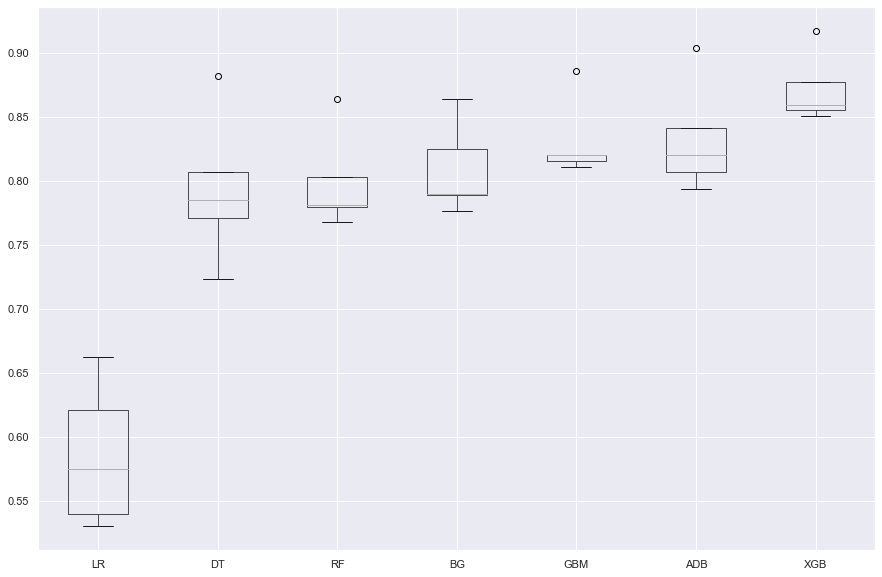

In [835]:
print('Comparing recall scores:')
kfold_results_step2.boxplot(grid=True, figsize=(15,10));

### Grid Search CV

In [ ]:
# Defining parameters together for convenience
# Will not run in loop as will take very long
parameters = {

    "LR": {
        'lr__penalty': ['l1','l2'],
        'lr__C': [0.2,0.5,0.7,1.0],
        'lr__class_weight':['balanced',None],
        'lr__solver': ['saga'],
        'lr__max_iter': [100,500,1000]
    },
            
    "DT": {
        'dt__max_depth': np.arange(2,30), 
        'dt__min_samples_leaf': [1, 2, 5, 7, 10],
        'dt__max_leaf_nodes' : [2, 3, 5, 10,15],
        'dt__min_impurity_decrease': [0.00001,0.0001,0.001,0.01,0.1], 
        'dt__class_weight':['balanced', None]
    },
    
    "RF": {  
        'rf__max_features': ['sqrt','log2','auto'],
        'rf__min_samples_leaf': np.arange(1,15,5),
        'rf__min_samples_split': np.arange(2, 20, 5),
        'rf__n_estimators': list(np.linspace(10, 50, 10, dtype = int)),
        'rf__class_weight':['balanced',None]
    },

    "BG": {
        'bg__base_estimator': [
            DecisionTreeClassifier(max_depth=1, random_state=random_state),
            DecisionTreeClassifier(max_depth=2, random_state=random_state),
            DecisionTreeClassifier(max_depth=3, random_state=random_state)],
        'bg__n_estimators':[5,7,15,51,101],
        'bg__max_features': [0.7,0.8,0.9,1]
    },

    "GBM": {
        'gb__n_estimators': [100,150,200,250],
        'gb__subsample':[0.8,0.9,1],
        'gb__max_features':[0.7,0.8,0.9,1]
    },

    "ADB": {
        'ad__n_estimators': np.arange(10, 110, 10),
        'ad__learning_rate': [0.1, 0.01, 0.2, 0.05, 1],
        'ad__base_estimator': [
            DecisionTreeClassifier(max_depth=1, random_state=random_state),
            DecisionTreeClassifier(max_depth=2, random_state=random_state),
            DecisionTreeClassifier(max_depth=3, random_state=random_state)]
    },
    
    "XGB": {
        'xg__n_estimators': np.arange(50,300,50),
        #'xg__scale_pos_weight': [0,1,2,5,10],
        'xg__learning_rate': [0.01,0.1,0.2,0.05], 
        #'xg__gamma': [0,1,3,5],
        'xg__subsample': [0.7,0.8,0.9,1],
        'xg__colsample_bytree': [0.5,0.7,1],
        'xg__colsample_bylevel': [0.5,0.7,1]
    }
}

### Logistic - Grid and RandomSearchCV

In [841]:
%%time

pipe = models['LR']
param_grid = parameters['LR']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

lr_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(lr_tuned_grid)

Best Parameters:{'lr__C': 0.5, 'lr__class_weight': 'balanced', 'lr__max_iter': 100, 'lr__penalty': 'l1', 'lr__solver': 'saga'} 
Score: 0.8454787850683978
Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    penalty='l1', random_state=314159,
                                    solver='saga'))])
CPU times: user 2min 11s, sys: 30 s, total: 2min 41s
Wall time: 21.1 s


In [844]:
%%time

pipe = models['LR']
param_grid = parameters['LR']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
lr_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(lr_tuned_rand)

Best parameters are {'lr__solver': 'saga', 'lr__penalty': 'l1', 'lr__max_iter': 100, 'lr__class_weight': 'balanced', 'lr__C': 0.5} with CV score=0.8454787850683978:
Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    penalty='l1', random_state=314159,
                                    solver='saga'))])
CPU times: user 2min 11s, sys: 28 s, total: 2min 39s
Wall time: 20.9 s


### Decision Tree - Grid and RandomSearch CV

In [846]:
%%time

pipe = models['DT']
param_grid = parameters['DT']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

dt_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(dt_tuned_grid)

Best Parameters:{'dt__class_weight': 'balanced', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 5, 'dt__min_impurity_decrease': 1e-05, 'dt__min_samples_leaf': 1} 
Score: 0.96575855939408
Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                                        max_leaf_nodes=5,
                                        min_impurity_decrease=1e-05,
                                        random_state=314159))])
CPU times: user 11min 50s, sys: 1.78 s, total: 11min 52s
Wall time: 11min 53s


In [847]:
%%time

pipe = models['DT']
param_grid = parameters['DT']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
dt_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(dt_tuned_rand)

Best parameters are {'dt__min_samples_leaf': 5, 'dt__min_impurity_decrease': 0.001, 'dt__max_leaf_nodes': 5, 'dt__max_depth': 6, 'dt__class_weight': 'balanced'} with CV score=0.96575855939408:
Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        max_leaf_nodes=5,
                                        min_impurity_decrease=0.001,
                                        min_samples_leaf=5,
                                        random_state=314159))])
CPU times: user 5.51 s, sys: 19 ms, total: 5.53 s
Wall time: 5.54 s


### Random Forest - Grid and RandomSearch CV

In [849]:
%%time

pipe = models['RF']
param_grid = parameters['RF']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

rf_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(rf_tuned_grid)

Best Parameters:{'rf__class_weight': 'balanced', 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 11, 'rf__min_samples_split': 2, 'rf__n_estimators': 50} 
Score: 0.8911507844501122
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        min_samples_leaf=11, n_estimators=50,
                                        random_state=314159))])
CPU times: user 10min 35s, sys: 2.73 s, total: 10min 37s
Wall time: 10min 38s


In [851]:
%%time

pipe = models['RF']
param_grid = parameters['RF']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
rf_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(rf_tuned_rand)

Best parameters are {'rf__n_estimators': 50, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 11, 'rf__max_features': 'sqrt', 'rf__class_weight': 'balanced'} with CV score=0.8911507844501122:
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        min_samples_leaf=11,
                                        min_samples_split=12, n_estimators=50,
                                        random_state=314159))])
CPU times: user 50.3 s, sys: 260 ms, total: 50.5 s
Wall time: 50.6 s


### Bagging - Grid and RandomSearch CV

In [852]:
%%time

pipe = models['BG']
param_grid = parameters['BG']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

bg_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(bg_tuned_grid)

Best Parameters:{'bg__base_estimator': DecisionTreeClassifier(max_depth=3, random_state=314159), 'bg__max_features': 0.9, 'bg__n_estimators': 7} 
Score: 0.7208091815441687
Pipeline(steps=[('scaler', StandardScaler()),
                ('bg',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                         random_state=314159),
                                   max_features=0.9, n_estimators=7,
                                   random_state=314159))])
CPU times: user 56.3 s, sys: 344 ms, total: 56.7 s
Wall time: 56.8 s


In [912]:
%%time

pipe = models['BG']
param_grid = parameters['BG']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
bg_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(bg_tuned_rand)

Best parameters are {'bg__n_estimators': 7, 'bg__max_features': 0.9, 'bg__base_estimator': DecisionTreeClassifier(max_depth=3, random_state=314159)} with CV score=0.7208091815441687:
Pipeline(steps=[('scaler', StandardScaler()),
                ('bg',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                         random_state=314159),
                                   max_features=0.9, n_estimators=7,
                                   random_state=314159))])
CPU times: user 46.2 s, sys: 279 ms, total: 46.5 s
Wall time: 46.6 s


### Adaboost - Grid and RandomSearch CV

In [859]:
%%time

pipe = models['ADB']
param_grid = parameters['ADB']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

ad_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(ad_tuned_grid)

Best Parameters:{'ad__base_estimator': DecisionTreeClassifier(max_depth=3, random_state=314159), 'ad__learning_rate': 0.2, 'ad__n_estimators': 100} 
Score: 0.8735721462245923
Pipeline(steps=[('scaler', StandardScaler()),
                ('ad',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=314159),
                                    learning_rate=0.2, n_estimators=100,
                                    random_state=314159))])
CPU times: user 6min 48s, sys: 1.29 s, total: 6min 50s
Wall time: 6min 50s


In [860]:
%%time

pipe = models['ADB']
param_grid = parameters['ADB']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
ad_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(ad_tuned_rand)

Best parameters are {'ad__n_estimators': 60, 'ad__learning_rate': 1, 'ad__base_estimator': DecisionTreeClassifier(max_depth=2, random_state=314159)} with CV score=0.8639307519901074:
Pipeline(steps=[('scaler', StandardScaler()),
                ('ad',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                          random_state=314159),
                                    learning_rate=1, n_estimators=60,
                                    random_state=314159))])
CPU times: user 1min 56s, sys: 333 ms, total: 1min 56s
Wall time: 1min 56s


### Gradient Grid and RandomSearch CV

In [861]:
%%time

pipe = models['GBM']
param_grid = parameters['GBM']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

gb_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(gb_tuned_grid)

Best Parameters:{'gb__max_features': 0.8, 'gb__n_estimators': 250, 'gb__subsample': 1} 
Score: 0.8771156967308137
Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(max_features=0.8, n_estimators=250,
                                            random_state=314159,
                                            subsample=1))])
CPU times: user 4min 30s, sys: 467 ms, total: 4min 31s
Wall time: 4min 31s


In [862]:
%%time

pipe = models['GBM']
param_grid = parameters['GBM']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
gb_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(gb_tuned_rand)

Best parameters are {'gb__subsample': 1, 'gb__n_estimators': 250, 'gb__max_features': 0.8} with CV score=0.8771156967308137:
Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(max_features=0.8, n_estimators=250,
                                            random_state=314159,
                                            subsample=1))])
CPU times: user 4min 24s, sys: 440 ms, total: 4min 24s
Wall time: 4min 25s


### XGBoost Grid and RandomSearch CV

In [875]:
%%time

pipe = models['XGB']
param_grid = parameters['XGB']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

xg_tuned_grid = grid_cv.best_estimator_
print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)
print(xg_tuned_grid)

Best Parameters:{'xg__colsample_bylevel': 1, 'xg__colsample_bytree': 0.7, 'xg__learning_rate': 0.1, 'xg__n_estimators': 250, 'xg__subsample': 0.8} 
Score: 0.8876188268026896
Pipeline(steps=[('scaler', StandardScaler()),
                ('xg',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=250,
                               n_jobs=16, num_parallel_tree=1,
                               random_state=314159, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight

In [874]:
%%time

pipe = models['XGB']
param_grid = parameters['XGB']

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
cv_obj = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=random_state)

#Fitting parameters in RandomizedSearchCV
cv_obj.fit(X_train,y_train)
xg_tuned_rand = cv_obj.best_estimator_
print("Best parameters are {} with CV score={}:" .format(cv_obj.best_params_, cv_obj.best_score_))
print(xg_tuned_rand)

Best parameters are {'xg__subsample': 1, 'xg__n_estimators': 250, 'xg__learning_rate': 0.2, 'xg__colsample_bytree': 1, 'xg__colsample_bylevel': 0.5} with CV score=0.8823556689079528:
Pipeline(steps=[('scaler', StandardScaler()),
                ('xg',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=250,
                               n_jobs=16, num_parallel_tree=1,
                               random_state=314159, reg_alpha=0, reg_lambda=1,
                               scale_p

In [903]:
xg_tuned_rand[1].colsample_bylevel # just checking that is indeed best model

0.5

In [883]:
grid_tuned_models = {'LR-grid':lr_tuned_grid, 'RF-grid':rf_tuned_grid, 'DT-grid':dt_tuned_grid, 'BG-grid':bg_tuned_grid, 'AD-grid':ad_tuned_grid, 'GB-grid':gb_tuned_grid, 'XG-grid':xg_tuned_grid}
rand_tuned_models = {'LR-rand':lr_tuned_rand, 'RF-rand':rf_tuned_rand, 'DT-rand':dt_tuned_rand, 'BG-rand':bg_tuned_rand, 'AD-rand':ad_tuned_rand, 'GB-rand':gb_tuned_rand, 'XG-rand':xg_tuned_rand}

In [880]:
grid_score_df = None
for key in grid_tuned_models:
    grid_score_df = model_score_df(grid_tuned_models[key], X_train, y_train, X_test, y_test, label=key, score_df=grid_score_df)

In [881]:
grid_score_df

LR-grid-train  LR-grid-test  RF-grid-train  \
model_accuracy                     0.847348      0.839421       0.960073   
model_recall_sensitivity_TPR       0.847234      0.860656       0.978929   
model_precision                    0.515216      0.500000       0.811499   
Specificity_TNR                    0.847369      0.835359       0.956463   
model_f1                           0.640770      0.632530       0.887386   
FPR                                0.152631      0.164641       0.043537   

                              RF-grid-test  DT-grid-train  DT-grid-test  \
model_accuracy                    0.943731       0.734058      0.721619   
model_recall_sensitivity_TPR      0.913934       0.968393      0.959016   
model_precision                   0.775652       0.373645      0.361669   
Specificity_TNR                   0.949432       0.689191      0.676205   
model_f1                          0.839135       0.539232      0.525253   
FPR                               0.050568       0.310809      0.323795   

                              BG-grid-train  BG-grid-test  AD-grid-train  \
model_accuracy                     0.918877      0.910826       0.992523   
model_recall_sensitivity_TPR       0.731343      0.727459       0.973661   
model_precision                    0.755898      0.720081       0.979682   
Specificity_TNR                    0.954782      0.945904       0.996134   
model_f1                           0.743418      0.723751       0.976662   
FPR                                0.045218      0.054096       0.003866   

                              AD-grid-test  GB-grid-train  GB-grid-test  \
model_accuracy                    0.973346       0.988431      0.975979   
model_recall_sensitivity_TPR      0.909836       0.951712      0.907787   
model_precision                   0.923077       0.975698      0.940552   
Specificity_TNR                   0.985496       0.995461      0.989024   
model_f1                          0.916409       0.963556      0.923879   
FPR                               0.014504       0.004539      0.010976   

                              XG-grid-train  XG-grid-test  
model_accuracy                          1.0      0.974005  
model_recall_sensitivity_TPR            1.0      0.909836  
model_precision                         1.0      0.926931  
Specificity_TNR                         1.0      0.986280  
model_f1                                1.0      0.918304  
FPR                                     0.0      0.013720

In [884]:
rand_score_df = None
for key in rand_tuned_models:
    rand_score_df = model_score_df(rand_tuned_models[key], X_train, y_train, X_test, y_test, label=key, score_df=rand_score_df)

In [885]:
rand_score_df

LR-rand-train  LR-rand-test  RF-rand-train  \
model_accuracy                     0.847348      0.839421       0.960073   
model_recall_sensitivity_TPR       0.847234      0.860656       0.978929   
model_precision                    0.515216      0.500000       0.811499   
Specificity_TNR                    0.847369      0.835359       0.956463   
model_f1                           0.640770      0.632530       0.887386   
FPR                                0.152631      0.164641       0.043537   

                              RF-rand-test  DT-rand-train  DT-rand-test  \
model_accuracy                    0.943731       0.734058      0.721619   
model_recall_sensitivity_TPR      0.913934       0.968393      0.959016   
model_precision                   0.775652       0.373645      0.361669   
Specificity_TNR                   0.949432       0.689191      0.676205   
model_f1                          0.839135       0.539232      0.525253   
FPR                               0.050568       0.310809      0.323795   

                              BG-rand-train  BG-rand-test  AD-rand-train  \
model_accuracy                     0.918877      0.910826       0.983493   
model_recall_sensitivity_TPR       0.731343      0.727459       0.935909   
model_precision                    0.755898      0.720081       0.960360   
Specificity_TNR                    0.954782      0.945904       0.992604   
model_f1                           0.743418      0.723751       0.947977   
FPR                                0.045218      0.054096       0.007396   

                              AD-rand-test  GB-rand-train  GB-rand-test  \
model_accuracy                    0.971043       0.988431      0.975979   
model_recall_sensitivity_TPR      0.899590       0.951712      0.907787   
model_precision                   0.918410       0.975698      0.940552   
Specificity_TNR                   0.984712       0.995461      0.989024   
model_f1                          0.908903       0.963556      0.923879   
FPR                               0.015288       0.004539      0.010976   

                              XG-rand-train  XG-rand-test  
model_accuracy                          1.0      0.976308  
model_recall_sensitivity_TPR            1.0      0.922131  
model_precision                         1.0      0.929752  
Specificity_TNR                         1.0      0.986672  
model_f1                                1.0      0.925926  
FPR                                     0.0      0.013328

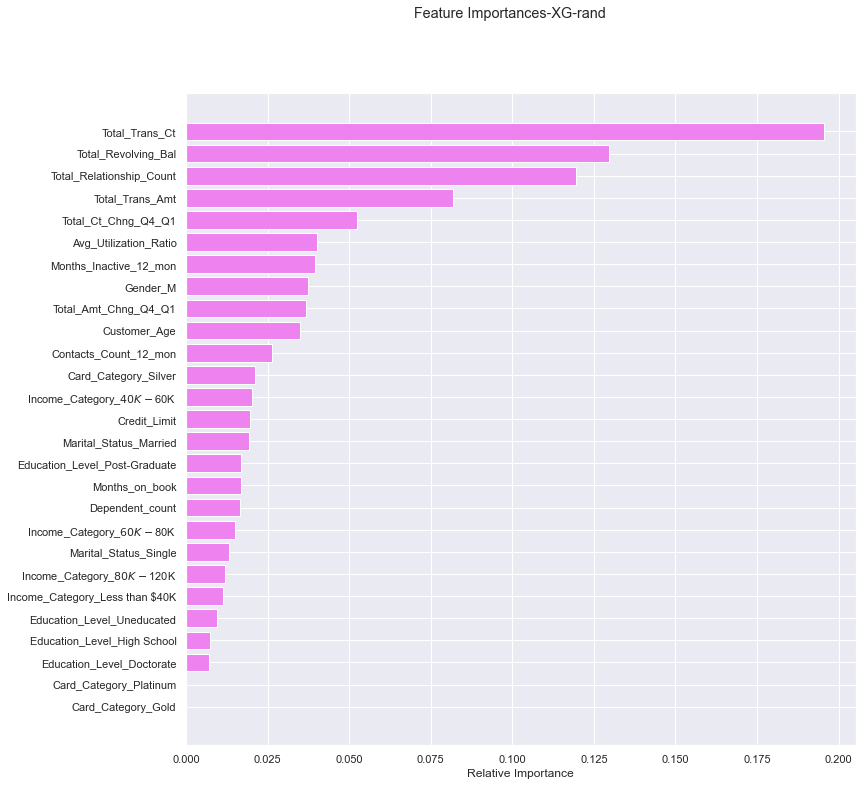

In [892]:
key = 'XG-rand'
feature_names = X_train.columns
importances = rand_tuned_models[key][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.suptitle("Feature Importances-"+key)
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

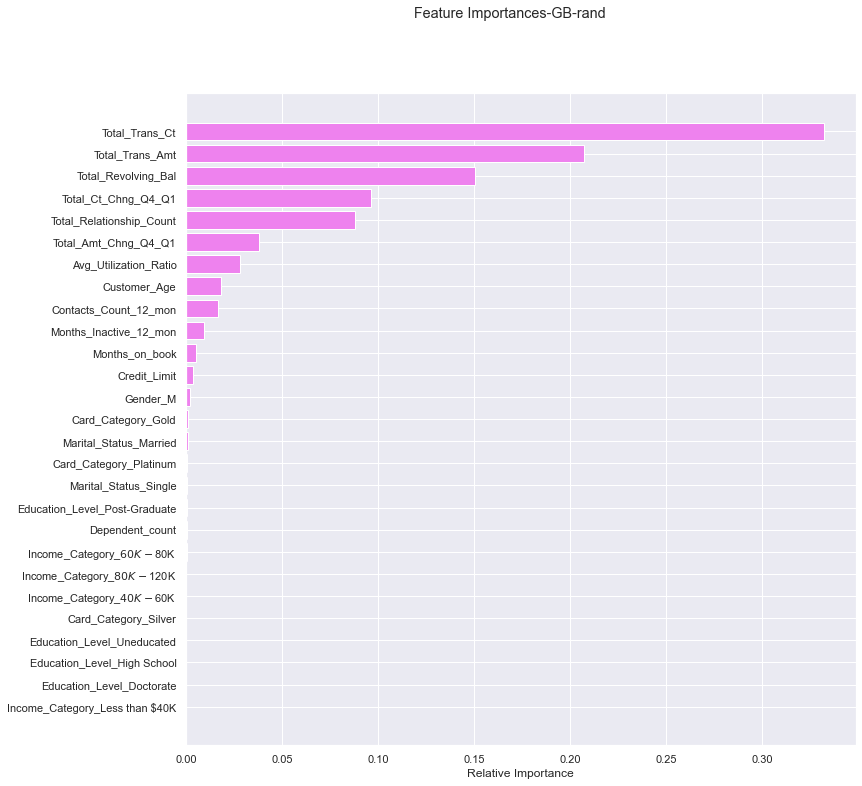

In [893]:
key = 'GB-rand'
feature_names = X_train.columns
importances = rand_tuned_models[key][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.suptitle("Feature Importances-"+key)
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

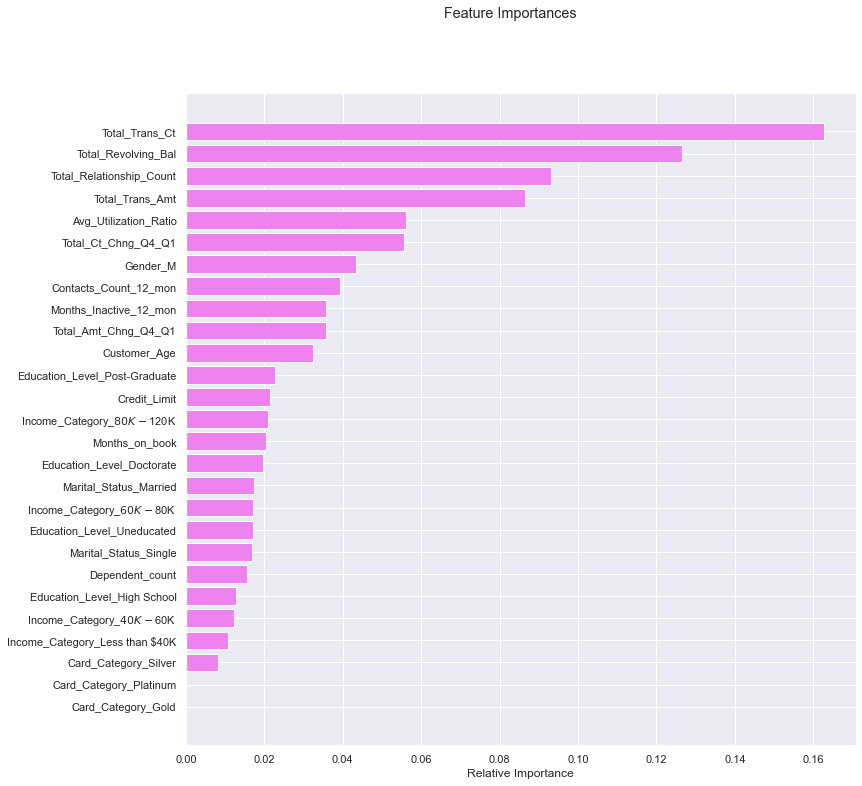

In [891]:
key = 'XG-grid'
feature_names = X_train.columns
importances = grid_tuned_models[key][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.suptitle("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

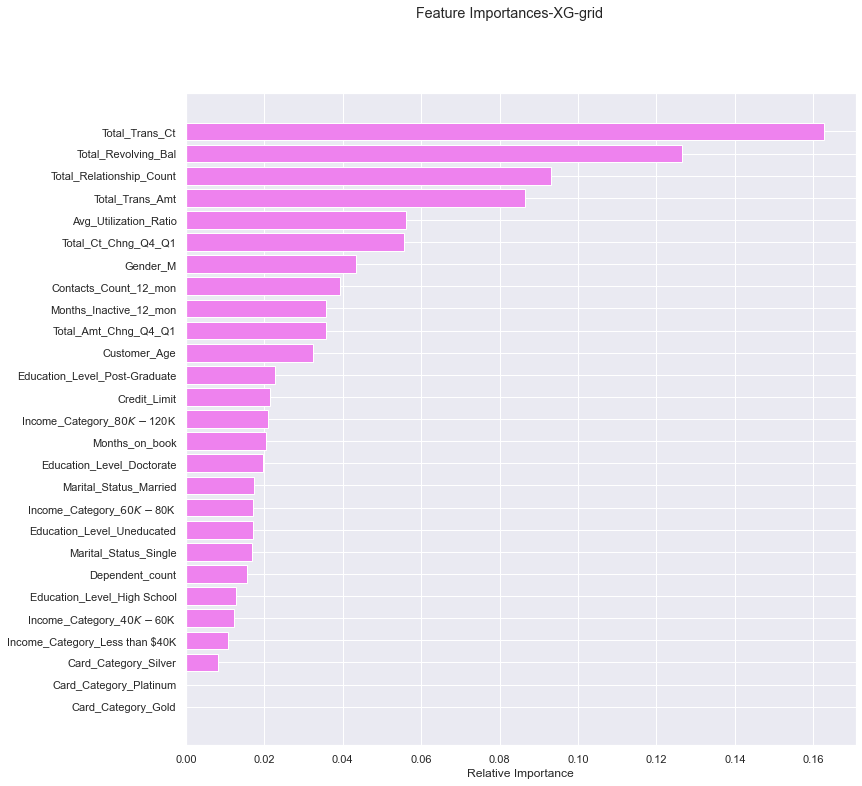

In [894]:
key = 'XG-grid'
feature_names = X_train.columns
importances = grid_tuned_models[key][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.suptitle("Feature Importances-"+key)
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

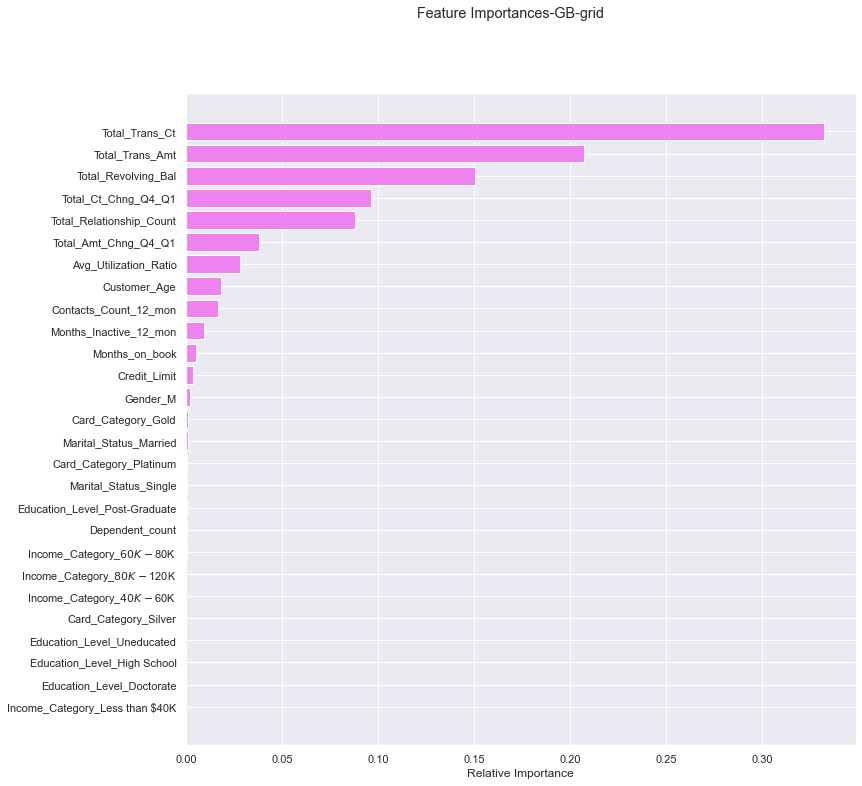

In [896]:
key = 'GB-grid'
feature_names = X_train.columns
importances = grid_tuned_models[key][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.suptitle("Feature Importances-"+key)
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

<h1><font color=red>need to add biz comm</h1></font>

Background & Context

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged on every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers’ and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help bank improve their services so that customers do not renounce their credit cards

Objective

    Explore and visualize the dataset.
    Build a classification model to predict if the customer is going to churn or not
    Optimize the model using appropriate techniques
    Generate a set of insights and recommendations that will help the bank

Data Dictionary:
* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1 else 0
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio

## Key Tasks
* Perform an Exploratory Data Analysis on the data
    - Univariate analysis - Bivariate analysis - Use appropriate visualizations to identify the patterns and insights - Any other exploratory deep dive
* Illustrate the insights based on EDA
    - Key meaningful observations on the relationship between variables
* Data Pre-processing
    - Prepare the data for analysis - Missing value Treatment, Outlier Detection(treat, if needed- why or why not ), Feature Engineering, Prepare data for modeling
* Model building - Logistic Regression
    - Make a logistic regression model - Improve model performance by up and downsampling the data - Regularize above models, if required
* Model building - Bagging and Boosting
    - Build Decision tree, random forest, bagging classifier models - Build Xgboost, AdaBoost, and gradient boosting models
* Hyperparameter tuning using grid search
    - Tune all the models using grid search - Use pipelines in hyperparameter tuning
* Hyperparameter tuning using random search
    - Tune all the models using ramdonized search - Use pipelines in hyperparameter tuning
* Model Performances
    - Compare the model performance of all the models - Comment on the time taken by the grid and randomized search in optimization
* Actionable Insights & Recommendations
    - Business recommendations and insights

